In [1]:
# Monitorization
import comet_ml
from comet_ml import start

import os

# Data
import numpy as np
import pandas as pd

# Audio
import librosa
import librosa.display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger, ReduceLROnPlateau
from sklearn.utils import shuffle

# Deep Learning Visualization
from sklearn.metrics import confusion_matrix

2025-01-09 08:41:25.614578: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 08:41:26.030297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 08:41:26.030529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 08:41:26.106732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 08:41:26.293054: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 08:41:26.295833: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Undestanding the Dataset
We have downloaded the Dataset Best of Watkins Marine Mammals from kaggle. It contains 37 classes, each of them with .wav files that contains sounds of each of the classes.

## Load Data

In [2]:
# !ls ../../Dataset/Audios/Watkins\ Marine\ Mammals

In [3]:
# # Main Folder with all classes and files
# main_folder = '../../Dataset/Audios/Watkins Marine Mammals/'

# # Folder contains subfolders = classes and in them, the audio sample
# classes = os.listdir(main_folder)

# # delete README.MD
# classes.remove('README.MD')

# # Create an empty list to store the audio file paths
# audio_files = []

# # Loop through all the subfolders and files
# for subfolder in classes:
#     # Get the list of all files in the subfolder
#     files = os.listdir(main_folder + subfolder)
#     # Loop through all the files
#     for f in files:
#         # Get the full path of the file
#         audio_files.append(main_folder + subfolder + '/' + f)

In [4]:
# df = pd.DataFrame(audio_files, columns=['File'])

# # Add class
# df['Class'] = df['File'].apply(lambda x: x.split('/')[-2])

In [5]:
# # Number of files per class and duration of each file
# for f in audio_files:
#     # Load the audio file
#     x, sr = librosa.load(f)
#     # Duration of the audio file
#     duration = librosa.get_duration(y=x, sr=sr)
#     # Add the duration to the duration list
#     df.loc[df['File'] == f, 'Duration'] = duration


# # Create an empty list to store the audio file paths
# audio_files = []


In [6]:
# # Save as CSV
# df.to_csv('../../Dataset/CSVs/WatkinsMarineMammals.csv', index=False)

In [7]:
# # show alphabetically by class name
# sorted_df.sort_values(by='Class')

In [8]:
# # 10 classes with the less files
# df['Class'].value_counts().tail(15)

### Split Dataset

Create train, validation and test datasets in 80%, 10% and 10% respectively.
Also create classes dictionary to map the classes to integers, alphabetically sorted.

In [9]:
def split_dataset(df, train_size=0.8, val_size=0.1, test_size=0.1):
    # Split the dataset into training, validation and test sets
    df_train, df_val = train_test_split(df, test_size=1-train_size, random_state=42, stratify=df['Class'])
    df_val, df_test = train_test_split(df_val, test_size=(test_size/(val_size+test_size)), random_state=42, stratify=df_val['Class'])

    # Create classes mapping alphabetically
    classes = df['Class'].unique()
    classes.sort()
    classes_mapping = {classes[i]: i for i in range(len(classes))}
    # Reverse the classes_mapping dictionary
    reverse_classes_mapping = {v: k for k, v in classes_mapping.items()}

    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_val = df_val.sample(frac=1).reset_index(drop=True)
    df_test = df_test.sample(frac=1).reset_index(drop=True)

    return df_train, df_val, df_test, classes, classes_mapping, reverse_classes_mapping

def plot_split(df_train, df_val, df_test):
    # Combine the datasets with an additional column indicating the set
    df_train['Set'] = 'Train'
    df_val['Set'] = 'Validation'
    df_test['Set'] = 'Test'

    # Concatenate all dataframes
    df_combined = pd.concat([df_train, df_val, df_test])

    # Plot number of files per class in each set not stacked
    plt.figure(figsize=(14, 8))
    sns.countplot(data=df_combined, x='Class', hue='Set')
    plt.title('Number of Files per Class in Each Set')
    plt.xticks(rotation=90, ha='right', fontsize=10)  # Adjust fontsize and alignment
    plt.legend(title='Set')
    plt.tight_layout()  # Adjust layout to make room for labels
    plt.show()

# Functions

In [10]:
def plot_results(df_results, reverse_classes_mapping, mode='random', classes=None):
    # If classes, select only specific classes
    if classes:
        df_results = df_results[df_results['PredictedClass'].isin(classes)]

    # Highest confidence
    if mode == 'max':
        # Select the 25 samples with the highest confidence
        samples = df_results.sort_values(by='Confidence', ascending=False).head(25)
    # Lowest confidence
    elif mode == 'min':
        # Select the 25 samples with the lowest confidence
        samples = df_results.sort_values(by='Confidence').head(25)
    # Random
    else: # mode == 'random':
        # Select 25 random samples
        samples = df_results.sample(25, random_state=42)

    # Create a grid of plots
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))

    # Flatten the axes
    axes = axes.ravel()

    # Loop through all the samples
    for i, (_, row) in enumerate(samples.iterrows()):
        # Get the true and predicted labels
        true_label = reverse_classes_mapping[row['True']]
        pred_label = reverse_classes_mapping[row['Predicted']]
        confidence = row['Confidence']
        
        # Get the color of the label
        color = 'green' if true_label == pred_label else 'red'
        
        # Calculate the mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=row['Signal'], sr=48000)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Plot the mel spectrogram
        axes[i].imshow(mel_spectrogram, origin='lower')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", color=color)
        axes[i].axis('off')

        # print(f"Path: {row['Path']}")

    plt.tight_layout()
    plt.show()

## Preprocess Audios

As most audios are 3 seconds more or less, the time windows that will be used will be 3 seconds

Sampling rate was 256000 but BirdNET takes 48000, so 48000 will be used. It just changes the resolution of the audio.

In [11]:
# # Function to preprocess audio
# def preprocess_audio(file_path, target_sr=48000, duration=3):
#     # Load audio
#     signal, sr = librosa.load(file_path, sr=target_sr, mono=True)
    
#     # Calculate the maximum length in samples and min length in samples
#     max_length = target_sr * duration  # e.g., 48000 * 3
#     min_length = target_sr * 1  # e.g., 48000 * 1
    
#     # If the signal is shorter than the desired length, pad with silence
#     if len(signal) <= max_length:
#         padding = max_length - len(signal)
#         pad_left = padding // 2
#         pad_right = padding - pad_left
#         signal = np.pad(signal, (pad_left, pad_right), mode='constant')
#         return [signal]
    
#     # If the signal is longer than the desired length, split into 3-second windows
#     elif len(signal) > max_length:
#         segments = []
#         for start in range(0, len(signal), max_length):
#             end = start + max_length
#             segment = signal[start:end]
#             if min_length < len(segment) <= max_length:
#                 padding = max_length - len(segment)
#                 pad_left = padding // 2
#                 pad_right = padding - pad_left
#                 segment = np.pad(segment, (pad_left, pad_right), mode='constant')
                    
#                 segments.append(segment)
#         return segments
    
#     # If the signal is exactly the desired length, return as is
#     else:
#         return [signal]

# Function to preprocess audio
def preprocess_audio(file_path, target_sr=48000, duration=3):
    # Load audio
    signal, sr = librosa.load(file_path, sr=target_sr, mono=True)
    
    # Calculate the maximum length in samples and min length in samples
    max_length = target_sr * duration  # e.g., 48000 * 3
    min_length = target_sr * 1  # e.g., 48000 * 1
    
    # If the signal is shorter than the desired length, pad with silence
    if len(signal) <= max_length:
        padding = max_length - len(signal)
        pad_left = padding // 2
        pad_right = padding - pad_left
        signal = np.pad(signal, (pad_left, pad_right), mode='constant')
        return [signal]
    
    # If the signal is longer than the desired length, split into 3-second windows
    elif len(signal) > max_length:
        segments = []

        # take the central 3 seconds segment
        start = (len(signal) - max_length) // 2
        end = start + max_length
        segment = signal[start:end]
        segments.append(segment)

        # for start in range(0, len(signal), max_length):
        #     end = start + max_length
        #     segment = signal[start:end]
        #     if min_length < len(segment) <= max_length:
        #         padding = max_length - len(segment)
        #         pad_left = padding // 2
        #         pad_right = padding - pad_left
        #         segment = np.pad(segment, (pad_left, pad_right), mode='constant')
                    
        #         segments.append(segment)
        return segments
    
    # If the signal is exactly the desired length, return as is
    else:
        return [signal]

# # Test preprocess on a single file
# sample_file = os.path.join(df_train["File"][0])
# processed_audios = preprocess_audio(sample_file, target_sr=48000, duration=3)

# # Visualize waveforms

# # print class
# print(f"Class: {df_train['Class'][0]}")

# processed_audio = processed_audios[0]
# plt.figure(figsize=(10, 4))
# librosa.display.waveshow(processed_audio, sr=48000)
# plt.title(f"Processed Audio Waveform")
# plt.show()

# # Mel spectrogram
# mel_spectrogram = librosa.feature.melspectrogram(y=processed_audio, sr=48000)
# mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# # Visualize mel spectrogram
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title(f"Mel Spectrogram")
# plt.tight_layout()
# plt.show()

# # Listen audio
# import IPython.display as ipd
# ipd.Audio(processed_audio, rate=48000)

In [12]:
# # take 25 random samples of different classes and plot in a grid with its class
# # Select 25 random samples
# random_samples = df_train.sample(25, random_state=42)

# # Create a grid of plots
# fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# # Flatten the axes
# axes = axes.ravel()

# # Loop through all the samples

# for i, (_, row) in enumerate(random_samples.iterrows()):
#     # Load the audio file
#     signal, sr = librosa.load(row['File'], sr=48000)

#     # preprocess the audio
#     processed_audios = preprocess_audio(row['File'], target_sr=48000, duration=3)
    
#     # Calculate the mel spectrogram
#     mel_spectrogram = librosa.feature.melspectrogram(y=processed_audios[0], sr=48000)
#     mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
#     # Plot the mel spectrogram
#     axes[i].imshow(mel_spectrogram, origin='lower')
#     axes[i].set_title(f"{row['Class']} ({classes_mapping[row['Class']]})")
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

# Data Generators

## Data Augmentation

In [13]:
from pydub import AudioSegment

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    augmented_signal = signal + noise_factor * noise
    return augmented_signal

def shift_time(signal, shift_max=0.4):
    shift = np.random.randint(int(shift_max * len(signal)))
    augmented_signal = np.roll(signal, shift)
    return augmented_signal

# Mix Up
def mix_up(signal1, signal2, alpha=0.5):
    mixed_signal = alpha * signal1 + (1 - alpha) * signal2
    return mixed_signal

In [14]:
# # Check data augmentation in the same audio, plot the original and the augmented audio with each of the changes
# # Load the audio file
# sample_file = df_train['File'][0]
# sample_file_1 = df_train['File'][1]
# signal, sr = librosa.load(sample_file, sr=48000)
# signal_1, sr_1 = librosa.load(sample_file_1, sr=48000)

# # preprocess the audio
# signal = preprocess_audio(sample_file, target_sr=48000, duration=3)[0]
# signal_1 = preprocess_audio(sample_file_1, target_sr=48000, duration=3)[0]

# # Add noise
# augmented_signal_noise = add_noise(signal, noise_factor=0.005)

# # Shift time
# augmented_signal_shift = shift_time(signal, shift_max=0.2)

# # Mix up
# augmented_signal_mix_up = mix_up(signal, signal_1, alpha=0.5)

# # Mel spectrograms
# mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=48000)
# mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# mel_spectrogram_noise = librosa.feature.melspectrogram(y=augmented_signal_noise, sr=48000)
# mel_spectrogram_noise = librosa.power_to_db(mel_spectrogram_noise, ref=np.max)

# mel_spectrogram_shift = librosa.feature.melspectrogram(y=augmented_signal_shift, sr=48000)
# mel_spectrogram_shift = librosa.power_to_db(mel_spectrogram_shift, ref=np.max)

# mel_spectrogram_mix_up = librosa.feature.melspectrogram(y=augmented_signal_mix_up, sr=48000)
# mel_spectrogram_mix_up = librosa.power_to_db(mel_spectrogram_mix_up, ref=np.max)

# # Visualize mel spectrogram
# plt.figure(figsize=(40, 8))
# plt.subplot(1, 4, 1)
# librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title(f'Original ({df_train["Class"][0]})', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 2)
# librosa.display.specshow(mel_spectrogram_noise, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Noise', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 3)
# librosa.display.specshow(mel_spectrogram_shift, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Shift', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 4)
# librosa.display.specshow(mel_spectrogram_mix_up, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title(f'Mix Up with {df_train["Class"][1]}', fontsize=20)
# plt.tight_layout()

In [15]:
def audio_data_generator(df, classes_list, classes_mapping, batch_size=32, target_sr=48000, duration=3, augment=False, df_background=[]):
    while True:
        X, y = [], []
        # shuffle the dataframe
        df = shuffle(df)
        # reset index
        df = df.reset_index(drop=True)
        for _, row in df.iterrows():
            file_path = row['File']
            cls_index = classes_mapping[row['Class']] # Ensure it is the same classes mapping
            signals = preprocess_audio(file_path, target_sr, duration)
            for signal in signals:
                if augment:
                    if np.random.rand() < 0.5:
                        signal = add_noise(signal)
                    if np.random.rand() < 0.5:
                        signal = shift_time(signal)
                    if np.random.rand() < 0.5:
                        # If background noise is provided
                        if len(df_background) > 0:
                            # random background noise
                            random_noise = df_background['File'][np.random.randint(0, len(df_background))]
                            noise_signals = preprocess_audio(random_noise, target_sr=48000, duration=3)
                            signal_1 = noise_signals[np.random.randint(0, len(noise_signals))]
                            signal = mix_up(signal, signal_1, alpha=0.5)
                        else:
                            signal_1 = preprocess_audio(df['File'][np.random.randint(0, len(df))], target_sr=48000, duration=3)[0]
                            signal = mix_up(signal, signal_1, alpha=0.5)
                
                X.append(signal)
                y.append(cls_index)
                
                if len(X) == batch_size:
                    X = np.array(X)
                    y = np.array(y)
                    X, y = shuffle(X, y)
                    y = to_categorical(y, num_classes=len(classes_list))
                    # print(f"Batch X shape: {X.shape}, y shape: {y.shape}")
                    yield X, y
                    X, y = [], []

def audio_data_generator_test(df, classes_list, classes_mapping, batch_size=32, target_sr=48000, duration=3):
    while True:
        XPath, X_segment, XSignal, y = [], [], [], []
        for _, row in df.iterrows():
            file_path = row['File']
            cls_index = classes_mapping[row['Class']]
            signals = preprocess_audio(file_path, target_sr, duration)
            for i, signal in enumerate(signals):
                XPath.append(file_path)
                X_segment.append(i)
                XSignal.append(signal)
                y.append(cls_index)
                
                if len(XSignal) == batch_size:
                    XSignal = np.array(XSignal)
                    y = np.array(y)
                    yield XPath, X_segment, XSignal, to_categorical(y, num_classes=len(classes_list))
                    XPath, X_segment, XSignal, y = [], [], [], []

# Test the generator with test_Df
# test_gen = audio_data_generator(df_test, CLASSES, CLASSES_MAPPING, batch_size=8, target_sr=48000, duration=3)
# X, y = next(test_gen)
# print(X.shape, y.shape)

In [16]:
# # take 25 random samples of different classes and plot in a grid with its class
# # Select 25 random samples
# random_samples = df_test.sample(25, random_state=42)

# # Create a grid of plots
# fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# # Flatten the axes
# axes = axes.ravel()

# # Loop through all the samples

# for i, (_, row) in enumerate(random_samples.iterrows()):
#     # Load the audio file
#     signal, sr = librosa.load(row['File'], sr=48000)

#     # preprocess the audio
#     processed_audios = preprocess_audio(row['File'], target_sr=48000, duration=3)
    
#     # Calculate the mel spectrogram
#     mel_spectrogram = librosa.feature.melspectrogram(y=processed_audios[0], sr=48000)
#     mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
#     # Plot the mel spectrogram
#     axes[i].imshow(mel_spectrogram, origin='lower')
#     axes[i].set_title(f"{row['Class']} ({classes_mapping[row['Class']]})")
#     axes[i].axis('off')

# plt.tight_layout()
# plt.title('Test Data with Data Augmentation')
# plt.show()

# Model Functions

In [17]:
import warnings
warnings.filterwarnings('ignore')

def load_base_model(model_path = 'BirdNET-Analyzer-V2.4/V2.4/BirdNET_GLOBAL_6K_V2.4_Model/', freeze = True, n_freeze = 4, classes=[]):
    model = tf.keras.models.load_model(model_path, compile=False).model

    # Get the output of the second to last layer
    output_layer = model.layers[-2].output

    # Add 3 dense layers: 512, 128 and len(classes)

    # Add a dense layer with 512 units and ReLU activation
    x = tf.keras.layers.Dense(256, activation='relu')(output_layer)

    # Add a dense layer with 128 units and ReLU activation
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # Add a dense layer with the number of classes and softmax activation
    output_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

    # output_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(model.output)

    # Create a new model
    model = tf.keras.models.Model(inputs=model.input, outputs=output_layer)

    # Compile
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'Sensitivity', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'CategoricalAccuracy', 'F1Score'])

    if freeze:
        # Freeze first layers
        for layer in model.layers[:-n_freeze]:
            layer.trainable = False

    print(model.summary())

    return model

def model_compile(model, optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy']):
    # Compile
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=metrics,
        ) 
    
    return model

def train_model(model, df_train, df_val, classes, classes_mapping, batch_size=8, target_sr=48000, duration=3, epochs=100, callbacks=None, doshuffle=True, doDataAugmentation=False, df_background=[]):
    # Training and Validation Generators

    # shuffle data
    if doshuffle:
        df_train = shuffle(df_train, random_state=42)
        df_val = shuffle(df_val, random_state=42)

    train_gen = audio_data_generator(df_train, classes, classes_mapping, batch_size=batch_size, target_sr=target_sr, duration=duration, augment=doDataAugmentation, df_background=df_background)
    val_gen = audio_data_generator(df_val, classes, classes_mapping, batch_size=batch_size, target_sr=target_sr, duration=duration)

    total_segments_train = df_train['Duration'].sum() // duration
    total_segments_val = df_val['Duration'].sum() // duration

    # Calculate steps per epoch and validation steps
    steps_per_epoch = total_segments_train // batch_size
    validation_steps = total_segments_val // batch_size

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        shuffle=doshuffle,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def plot_training_monitoring(history):
    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

def evaluate_model(model, df_test, classes, classes_mapping, reverse_classes_mapping, batch_size=1, target_sr=48000, duration=3, plot_confusion_matrix=True):
    # Evaluate on test data
    # calculate total segments of 3 seconds in df_Test (summatory of Duration of each file) / 3
    test_gen = audio_data_generator(df_test, classes, classes_mapping, batch_size=batch_size)

    total_segments = int(df_test['Duration'].sum() / duration)

    test_steps = total_segments // batch_size

    results = model.evaluate(test_gen, steps=test_steps)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

    # predict all samples of df_test and get XPath, X_segment, XSignal, y_true and y_predicted
    test_gen = audio_data_generator_test(df_test, classes, classes_mapping, batch_size=batch_size)
    y_true = []
    y_predicted = []
    XPath = []
    X_segment = []
    XSignal = []

    for i in range(test_steps):
        XPath_batch, X_segment_batch, XSignal_batch, y_true_batch = next(test_gen)
        y_predicted_batch = model.predict(XSignal_batch, verbose=0)
        y_true.append(y_true_batch)
        y_predicted.append(y_predicted_batch)
        XPath.extend(XPath_batch)
        X_segment.extend(X_segment_batch)
        XSignal.extend(XSignal_batch)

    y_true = np.vstack(y_true)
    y_predicted = np.vstack(y_predicted)

    # Get the predicted classes and confidence
    y_pred_classes = np.argmax(y_predicted, axis=1)
    y_pred_confidence = np.max(y_predicted, axis=1)

    y_pred = np.vstack((y_pred_classes, y_pred_confidence))
    y_true = np.argmax(y_true, axis=1)

    # Accuracy manual
    # accuracy_manual = np.mean(y_pred_classes == y_true)
    # print(f"Accuracy from model.evaluate: {results[1]}")
    # print(f"Manual accuracy: {accuracy_manual}")

    if plot_confusion_matrix:
        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(30, 30))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # Normalized by rows
        cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(30, 30))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    # Put together X_eval, y_true, y_pred_classes, y_pred_confidence
    df_results = pd.DataFrame({
        'Path': list(XPath),
        'SegmentIdx': list(X_segment),
        'Signal': list(XSignal),
        'True': y_true,
        'Predicted': y_pred_classes,
        'PredictedClass': [reverse_classes_mapping[p] for p in y_pred_classes],
        'Confidence': y_pred_confidence
    })

    return df_results

# Experiment: Only Strait of Gibraltar Classes + BG ST Gibraltar + Data Augmentation

## Dataset

### Watkins Marine Mammals

In [18]:
df_wmm = pd.read_csv('../../Dataset/CSVs/WatkinsMarineMammals.csv')

In [19]:
df_wmm

File               Class  \
0      ../../Dataset/Audios/Watkins Marine Mammals/Wh...  White_sidedDolphin   
1      ../../Dataset/Audios/Watkins Marine Mammals/Wh...  White_sidedDolphin   
2      ../../Dataset/Audios/Watkins Marine Mammals/Wh...  White_sidedDolphin   
3      ../../Dataset/Audios/Watkins Marine Mammals/Wh...  White_sidedDolphin   
4      ../../Dataset/Audios/Watkins Marine Mammals/Wh...  White_sidedDolphin   
...                                                  ...                 ...   
15527  ../../Dataset/Audios/Watkins Marine Mammals/Ri...          RingedSeal   
15528  ../../Dataset/Audios/Watkins Marine Mammals/Ri...          RingedSeal   
15529  ../../Dataset/Audios/Watkins Marine Mammals/Ri...          RingedSeal   
15530  ../../Dataset/Audios/Watkins Marine Mammals/Ri...          RingedSeal   
15531  ../../Dataset/Audios/Watkins Marine Mammals/Ri...          RingedSeal   

       Duration  
0      2.521905  
1      2.069887  
2      2.215329  
3      2.742222  
4      1.437052  
...         ...  
15527  0.458639  
15528  0.334014  
15529  1.418005  
15530  0.773469  
15531  0.117324  

[15532 rows x 3 columns]

In [20]:
# Take only sperm whale
df_PM = df_wmm[df_wmm['Class'] == 'SpermWhale']
df_wmm = df_wmm[df_wmm['Class'] != 'SpermWhale']
# take x random samples
df_PM = df_PM.sample(250, random_state=42).reset_index(drop=True)
# Concatenate dataframes
df_wmm = pd.concat([df_wmm, df_PM])
df_wmm = df_wmm.reset_index(drop=True)

In [21]:
# Take only classes: BottlenoseDolphin, 'BowheadWhale', 'CommonDolphin', 'Fin_FinbackWhale', "Grampus_Risso'sDolphin, 'HarborPorpoise, 'HumpbackWhale, 'KillerWhale, 'Long_FinnedPilotWhale', 'MinkeWhale, 'Rough_ToothedDolphin', 'SpermWhale, 'StripedDolphin'
df_wmm = df_wmm[df_wmm['Class'].isin(['BottlenoseDolphin', 'CommonDolphin', 'Fin_FinbackWhale', "Grampus_Risso'sDolphin", 'HarborPorpoise', 'HumpbackWhale', 'KillerWhale', 'Long_FinnedPilotWhale', 'MinkeWhale', 'SpermWhale', 'StripedDolphin'])]
df_wmm = df_wmm.reset_index(drop=True)

In [22]:
df_wmm

File  \
0     ../../Dataset/Audios/Watkins Marine Mammals/Lo...   
1     ../../Dataset/Audios/Watkins Marine Mammals/Lo...   
2     ../../Dataset/Audios/Watkins Marine Mammals/Lo...   
3     ../../Dataset/Audios/Watkins Marine Mammals/Lo...   
4     ../../Dataset/Audios/Watkins Marine Mammals/Lo...   
...                                                 ...   
7475  ../../Dataset/Audios/Watkins Marine Mammals/Sp...   
7476  ../../Dataset/Audios/Watkins Marine Mammals/Sp...   
7477  ../../Dataset/Audios/Watkins Marine Mammals/Sp...   
7478  ../../Dataset/Audios/Watkins Marine Mammals/Sp...   
7479  ../../Dataset/Audios/Watkins Marine Mammals/Sp...   

                      Class     Duration  
0     Long_FinnedPilotWhale     2.416009  
1     Long_FinnedPilotWhale     1.897506  
2     Long_FinnedPilotWhale     1.660136  
3     Long_FinnedPilotWhale     1.695420  
4     Long_FinnedPilotWhale     1.036916  
...                     ...          ...  
7475             SpermWhale     5.566667  
7476             SpermWhale   218.145034  
7477             SpermWhale    17.812517  
7478             SpermWhale  1179.215374  
7479             SpermWhale     2.847483  

[7480 rows x 3 columns]

In [23]:
# split wmm
df_train_wmm, df_val_wmm, df_test_wmm, CLASSES, CLASSES_MAPPING, REVERSE_CLASSES_MAPPING = split_dataset(df_wmm, train_size=0.7, val_size=0.15, test_size=0.15)

### Neus - Marine Mammals

In [24]:
# Main Folder with all classes and files
main_folder = '../../Dataset/Audios/Neus/'

# Folder contains subfolders = classes and in them, the audio sample
classes = os.listdir(main_folder)

# delete README.MD
# classes.remove('README.MD')

# Create an empty list to store the audio file paths
audio_files = []

# Loop through all the subfolders and files
for subfolder in classes:
    # Get the list of all files in the subfolder
    files = os.listdir(main_folder + subfolder)
    # Loop through all the files
    for f in files:
        # Get the full path of the file
        audio_files.append(main_folder + subfolder + '/' + f)

df_neus_mm = pd.DataFrame(audio_files, columns=['File'])

# Add class
df_neus_mm['Class'] = df_neus_mm['File'].apply(lambda x: x.split('/')[-2])

# Number of files per class and duration of each file
for f in audio_files:
    # Load the audio file
    x, sr = librosa.load(f)
    # Duration of the audio file
    duration = librosa.get_duration(y=x, sr=sr)
    # Add the duration to the duration list
    df_neus_mm.loc[df_neus_mm['File'] == f, 'Duration'] = duration

# If Class Dd then CommonDolphin, Gm then Grampus_Risso'sDolphin, Hb then HumpbackWhale, Kk then KillerWhale, Lf then Long_FinnedPilotWhale, Mw then MinkeWhale, Rt then Rough_ToothedDolphin, Sw then SpermWhale, Sd then StripedDolphin
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: 'CommonDolphin' if x == 'Dd' else x)
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: "Long_FinnedPilotWhale" if x == 'Gm' else x)
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: 'KillerWhale' if x == 'Oo' else x)
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: 'SpermWhale' if x == 'Pm' else x)
df_neus_mm['Class'] = df_neus_mm['Class'].apply(lambda x: 'StripedDolphin' if x == 'Sc' else x)

In [25]:
# row with KillerWhale extract
df_KW = df_neus_mm[df_neus_mm['Class'] == 'KillerWhale'] # 1 audio
# row with SpermWhale extract
df_SW = df_neus_mm[df_neus_mm['Class'] == 'SpermWhale'] # 2 audios
# row with StripDolphin extract
df_SD = df_neus_mm[df_neus_mm['Class'] == 'StripedDolphin'] # 1 audio

# df_neus is all but the 3 classes
df_neus_mm = df_neus_mm[~df_neus_mm['Class'].isin(['KillerWhale', 'SpermWhale', 'StripedDolphin'])]

In [26]:
# split neus
df_train_neus, df_val_neus, df_test_neus_mm, _, _, _ = split_dataset(df_neus_mm, train_size=0.7, val_size=0.15, test_size=0.15)

In [27]:
# add KillerWhale and StripedDolphin to train
df_train_neus = pd.concat([df_train_neus, df_KW, df_SD])
# Split SpermWhale in half for train and validation
df_train_neus = pd.concat([df_train_neus, df_SW.iloc[:1]])
df_val_neus = pd.concat([df_val_neus, df_SW.iloc[1:]])

### SEANIMALMOVE - Background (no clicks, no whistles)

In [28]:
# Load CSV
df_sam_background = pd.read_csv('../../Dataset/CSVs/DatasetMultiLabel3.csv')
# Insert in path ../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/{Path}
df_sam_background['File'] = df_sam_background['SegmentPath'].apply(lambda x: f"../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/{x}")
# Take only rows where NumClasses = 0
# df_sam_background = df_sam_background[df_sam_background['NumClasses'] == 0]

# Take only rows where Class list does not contains CLICK, Whistle,Batida,BatidaClicks or BatidaClicksRapidaCascabel
df_sam_background = df_sam_background[~df_sam_background['Class'].str.contains('CLICK|Whistle|Batida|BatidaClicks|BatidaClicksRapidaCascabel')]
df_sam_background_empty = df_sam_background[df_sam_background['NumClasses'] == 0]
df_sam_background = df_sam_background[df_sam_background['NumClasses'] > 0]
# Take 1000 random samples of the background
df_sam_background = df_sam_background.sample(min(4000, len(df_sam_background)), random_state=42).reset_index(drop=True)
df_sam_background_empty = df_sam_background_empty.sample(min(len(df_sam_background), len(df_sam_background_empty)), random_state=42).reset_index(drop=True)
df_sam_background = pd.concat([df_sam_background, df_sam_background_empty])
# Create Column Duration and set all to 3
df_sam_background['Duration'] = 3
# Keep only columns Path, Class and Duration
df_sam_background = df_sam_background[['File', 'Class', 'Duration']]
# Class column value = Background
df_sam_background['Class'] = 'Background'

In [29]:
df_train_bg, df_val_bg, df_test_sam_bg, _, _, _ = split_dataset(df_sam_background, train_size=0.7, val_size=0.15, test_size=0.15)

## Neus - Background (Anthropogenic, ferries)

In [30]:
# Background ferries
# Read all audio files in the input folder and its subfolders and set them as class Background
# Main Folder with all classes and files
main_folder = '../../Dataset/Audios/NeusAnt/Anthropogenic/'

# Look for any .wav file in the folder or any subfolder
audio_files = []
for root, _, files in os.walk(main_folder):
    for file in files:
        if file.endswith('.wav'):
            audio_files.append(os.path.join(root, file))

df_bg_ff_neus = pd.DataFrame(audio_files, columns=['File'])

# Add class
df_bg_ff_neus['Class'] = "Background"
# total_duration = 0
# Number of files per class and duration of each file
for f in audio_files:
    
    # Load the audio file
    x, sr = librosa.load(f)
    # Duration of the audio file
    duration = librosa.get_duration(y=x, sr=sr)
    # Add the duration to the duration list
    df_bg_ff_neus.loc[df_bg_ff_neus['File'] == f, 'Duration'] = duration
    # total_duration += duration

# Take half of the files by randomness
df_bg_ff_neus = df_bg_ff_neus.sample(len(df_bg_ff_neus) // 2, random_state=42).reset_index(drop=True)

In [31]:
# Split background
df_train_bg_ff_neus, df_val_bg_ff_neus, df_test_bg_ff_neus, _, _, _ = split_dataset(df_bg_ff_neus, train_size=0.7, val_size=0.15, test_size=0.15)

In [32]:
# Add class Background to classes
CLASSES = np.append(CLASSES, 'Background')
# sORT alphabetically
CLASSES.sort()

# include CLASSES_MAPPING, REVERSE_CLASSES_MAPPING the background class as the first class
CLASSES_MAPPING = {CLASSES[i]: i for i in range(len(CLASSES))}
REVERSE_CLASSES_MAPPING = {v: k for k, v in CLASSES_MAPPING.items()}
CLASSES, CLASSES_MAPPING, REVERSE_CLASSES_MAPPING

(array(['Background', 'BottlenoseDolphin', 'CommonDolphin',
        'Fin_FinbackWhale', "Grampus_Risso'sDolphin", 'HarborPorpoise',
        'HumpbackWhale', 'KillerWhale', 'Long_FinnedPilotWhale',
        'MinkeWhale', 'SpermWhale', 'StripedDolphin'], dtype=object),
 {'Background': 0,
  'BottlenoseDolphin': 1,
  'CommonDolphin': 2,
  'Fin_FinbackWhale': 3,
  "Grampus_Risso'sDolphin": 4,
  'HarborPorpoise': 5,
  'HumpbackWhale': 6,
  'KillerWhale': 7,
  'Long_FinnedPilotWhale': 8,
  'MinkeWhale': 9,
  'SpermWhale': 10,
  'StripedDolphin': 11},
 {0: 'Background',
  1: 'BottlenoseDolphin',
  2: 'CommonDolphin',
  3: 'Fin_FinbackWhale',
  4: "Grampus_Risso'sDolphin",
  5: 'HarborPorpoise',
  6: 'HumpbackWhale',
  7: 'KillerWhale',
  8: 'Long_FinnedPilotWhale',
  9: 'MinkeWhale',
  10: 'SpermWhale',
  11: 'StripedDolphin'})

## Final Dataset

In [33]:
# Concat all dataframes
df_train = pd.concat([df_train_wmm, df_train_neus, df_train_bg, df_train_bg_ff_neus])
df_val = pd.concat([df_val_wmm, df_val_neus, df_val_bg, df_val_bg_ff_neus])
df_test = pd.concat([df_test_wmm, df_test_neus_mm, df_test_sam_bg, df_test_bg_ff_neus])

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [34]:
df_background = pd.concat([df_train_bg, df_train_bg_ff_neus])
df_background = df_background.reset_index(drop=True)

In [35]:
# Create df with column Set
df_train['Set'] = 'Train'
df_val['Set'] = 'Validation'
df_test['Set'] = 'Test'

# Concatenate all dataframes
df = pd.concat([df_train, df_val, df_test])

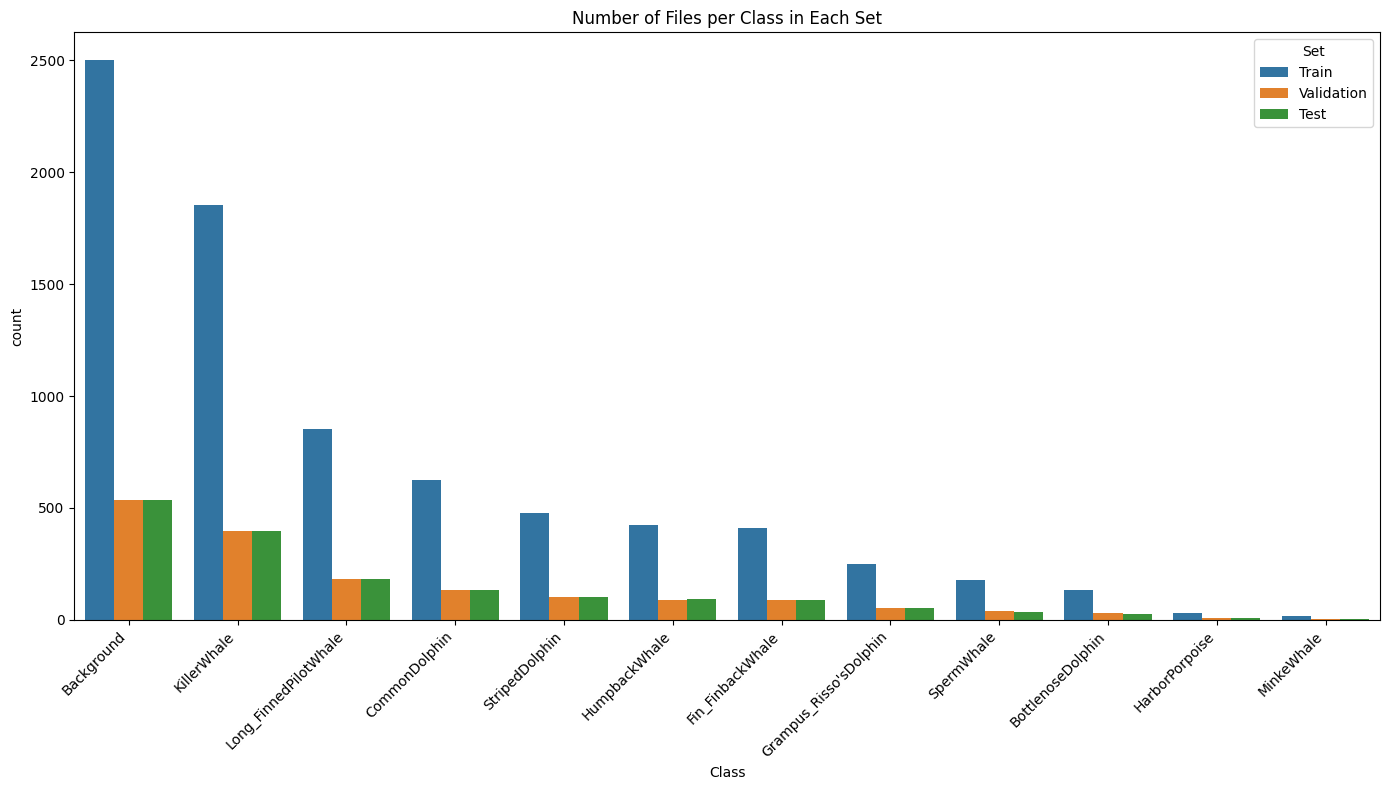

In [36]:
# Plot count per class, each subset is a bar for each class (train, val and test)
class_counts = df['Class'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Class', hue='Set', order=class_counts.index)
plt.title('Number of Files per Class in Each Set')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust fontsize and alignment
plt.legend(title='Set')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

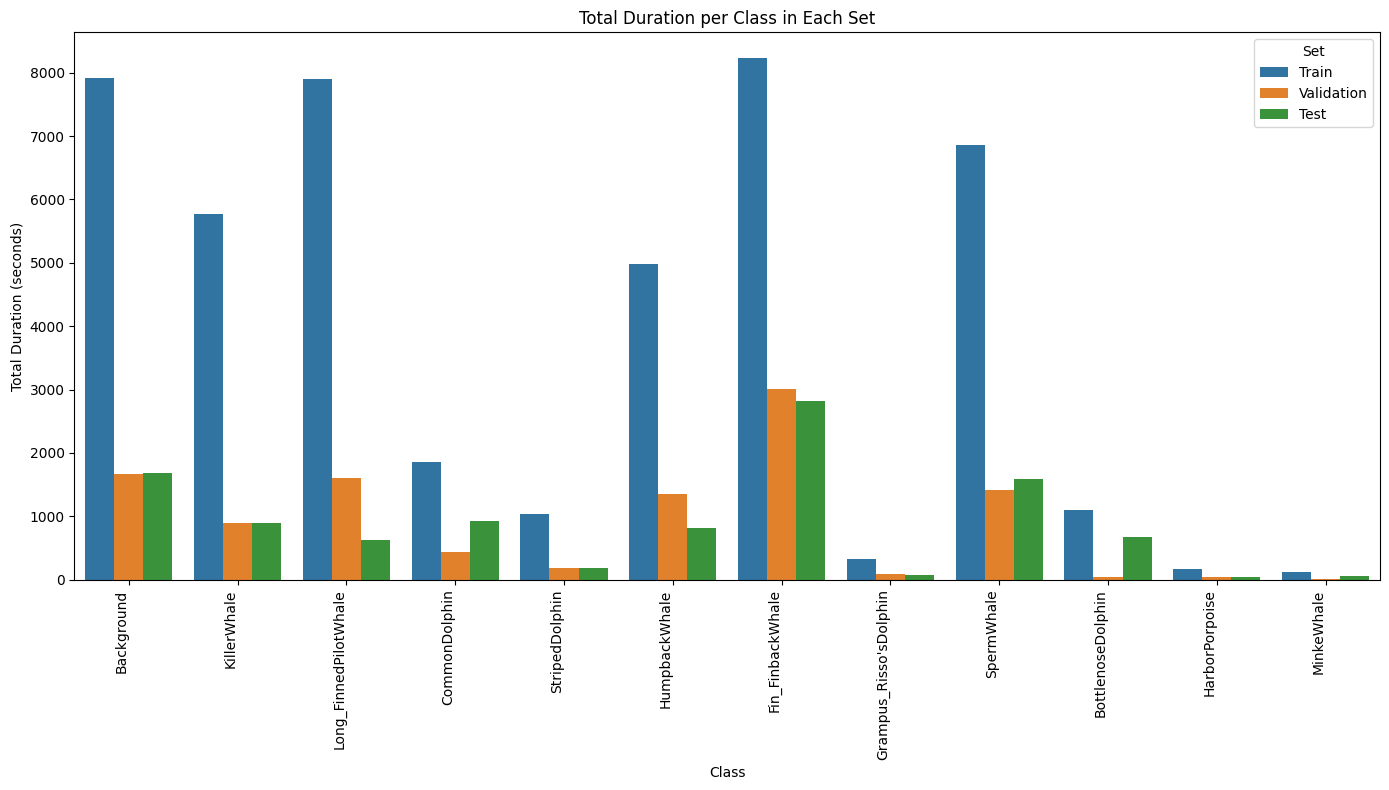

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_train, df_val, df_test are already defined and have a 'Duration' column

# Add 'Set' column
df_train['Set'] = 'Train'
df_val['Set'] = 'Validation'
df_test['Set'] = 'Test'

# Concatenate all dataframes
df = pd.concat([df_train, df_val, df_test])

# Aggregate total duration per class and subset
duration_df = df.groupby(['Class', 'Set'])['Duration'].sum().reset_index()

# Ensure the order of the bars is Train, Validation, and Test
duration_df['Set'] = pd.Categorical(duration_df['Set'], categories=['Train', 'Validation', 'Test'], ordered=True)

# Plot the total duration per class and subset
plt.figure(figsize=(14, 8))
sns.barplot(data=duration_df, x='Class', y='Duration', hue='Set', order=class_counts.index)
plt.title('Total Duration per Class in Each Set')
plt.xticks(rotation=90, ha='right', fontsize=10)  # Adjust fontsize and alignment
plt.ylabel('Total Duration (seconds)')
plt.legend(title='Set')
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [38]:
# reset index in all sets
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [39]:
CLASSES_MAPPING

{'Background': 0,
 'BottlenoseDolphin': 1,
 'CommonDolphin': 2,
 'Fin_FinbackWhale': 3,
 "Grampus_Risso'sDolphin": 4,
 'HarborPorpoise': 5,
 'HumpbackWhale': 6,
 'KillerWhale': 7,
 'Long_FinnedPilotWhale': 8,
 'MinkeWhale': 9,
 'SpermWhale': 10,
 'StripedDolphin': 11}

In [40]:
# experiment.end()

In [41]:
from private_credentials import API_COMETML
experiment = start(
  api_key=API_COMETML,
  project_name="Cetaceans",
  workspace="gruncrow",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/gruncrow/cetaceans/46b1439d788045dc84190afd796ed1eb



## Load and compile model

In [42]:
EXPERIMENT = "16_MarineMammals_NewDSGenerator"

OPTIMIZER = "adam"
LOSS = "categorical_crossentropy" #"categorical_crossentropy" # categorical_focal_crossentropy
# Best metric for umbalanced data - f1 or AUC PR
AUC_PR = tf.keras.metrics.AUC(curve="PR", name='AUC_PR')
F1ScoreMicro = tf.keras.metrics.F1Score(average='micro', name='f1_score_micro')
F1ScoreMacro = tf.keras.metrics.F1Score(average='macro', name='f1_score_macro')
F1ScoreWeighted = tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
METRICS = [AUC_PR, "accuracy"]
# , accuracy 'AUC', 'Precision', 'Recall', 'Sensitivity', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'CategoricalAccuracy', 'F1Score'

BATCH_SIZE = 4
EPOCHS = 100
SHUFFLE = True

PATIENCE = 5

# Callbacks
CALLBACKS = [
    ModelCheckpoint(f"Models/{EXPERIMENT}/best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1),
    EarlyStopping(patience=PATIENCE, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1),
    CSVLogger(f"Models/{EXPERIMENT}/training_log.csv", append=True),
    # LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20)),
    # ReduceLROnPlateau(monitor="val_loss",factor=0.5, min_lr=0.0001, patience=5, verbose=1)
]

In [43]:
model = load_base_model(classes=CLASSES)
model = model_compile(
    model, 
    optimizer=OPTIMIZER, 
    loss=LOSS, 
    metrics=METRICS
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 MEL_SPEC1 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                                  
 MEL_SPEC2 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                              

In [44]:
# test datagen
test_gen = audio_data_generator(df_test, CLASSES, CLASSES_MAPPING, batch_size=8, target_sr=48000, duration=3)
X, y = next(test_gen)
print(X.shape, y.shape)

(8, 144000) (8, 12)


## Train Model

In [45]:
model, history = train_model(model, df_train, df_val, classes=CLASSES, classes_mapping = CLASSES_MAPPING, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=CALLBACKS, doshuffle=SHUFFLE, doDataAugmentation=True, df_background=df_background)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/100
3856/3856 [==============================] - ETA: 0s - loss: 0.4685 - AUC_PR: 0.9311 - accuracy: 0.8590
Epoch 1: val_accuracy improved from -inf to 0.93345, saving model to Models/16_MarineMammals_NewDSGenerator/best_model.h5
3856/3856 [==============================] - 620s 157ms/step - loss: 0.4685 - AUC_PR: 0.9311 - accuracy: 0.8590 - val_loss: 0.2193 - val_AUC_PR: 0.9811 - val_accuracy: 0.9334
Epoch 2/100
3856/3856 [==============================] - ETA: 0s - loss: 0.2965 - AUC_PR: 0.9661 - accuracy: 0.9073
Epoch 2: val_accuracy improved from 0.93345 to 0.93988, saving model to Models/16_MarineMammals_NewDSGenerator/best_model.h5
3856/3856 [==============================] - 595s 154ms/step - loss: 0.2965 - AUC_PR: 0.9661 - accuracy: 0.9073 - val_loss: 0.2025 - val_AUC_PR: 0.9826 - val_accuracy: 0.9399
Epoch 3/100
3856/3856 [==============================] - ETA: 0s - loss: 0.2479 - AUC_PR: 0.9741 - accuracy: 0.9214
Epoch 3: val_accuracy did not improve from 0.93988
3856

In [60]:
model.save(f"Models/{EXPERIMENT}/")
print("Model saved: ", f"Models/{EXPERIMENT}/")

INFO:tensorflow:Assets written to: Models/16_MarineMammals_NewDSGenerator/assets


INFO:tensorflow:Assets written to: Models/16_MarineMammals_NewDSGenerator/assets


Model saved:  Models/16_MarineMammals_NewDSGenerator/


: 

In [47]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : glamorous_manatee_8914
COMET INFO:     url                   : https://www.comet.com/gruncrow/cetaceans/46b1439d788045dc84190afd796ed1eb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     AUC_PR [16]                    : (0.9311440587043762, 0.9884335994720459)
COMET INFO:     accuracy [16]                  : (0.8589860200881958, 0.9584413766860962)
COMET INFO:     batch_AUC_PR [6176]            : (0.09942834079265594, 1.0)
COMET INFO:     batch_accuracy [6176]          : (0.0, 1.0)
COMET INFO:     batch_loss [6176]              : (3.066481076530181e-05, 2.432593822479248)
COMET INFO:     epoch_duration [16]            : (303.2381879230088, 57

## Monitor Training

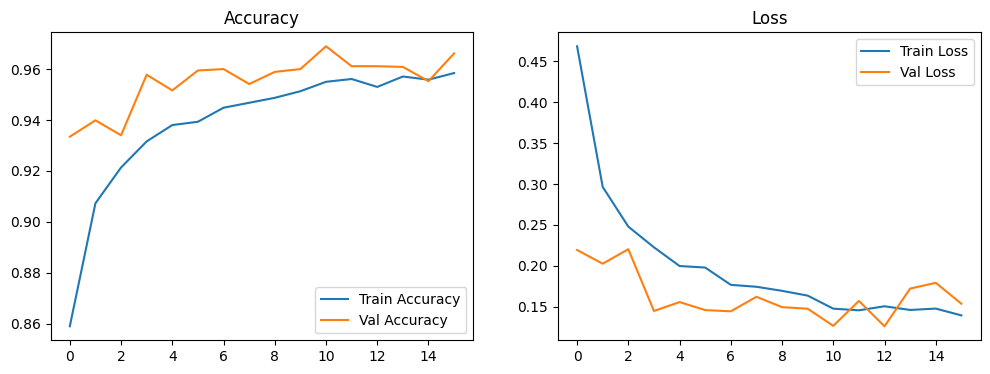

In [49]:
plot_training_monitoring(history)

## Evaluate Model

432/432 [==============================] - 55s 128ms/step - loss: 0.1358 - AUC_PR: 0.9909 - accuracy: 0.9708
Test Loss: 0.13577516376972198, Test Accuracy: 0.9909234046936035


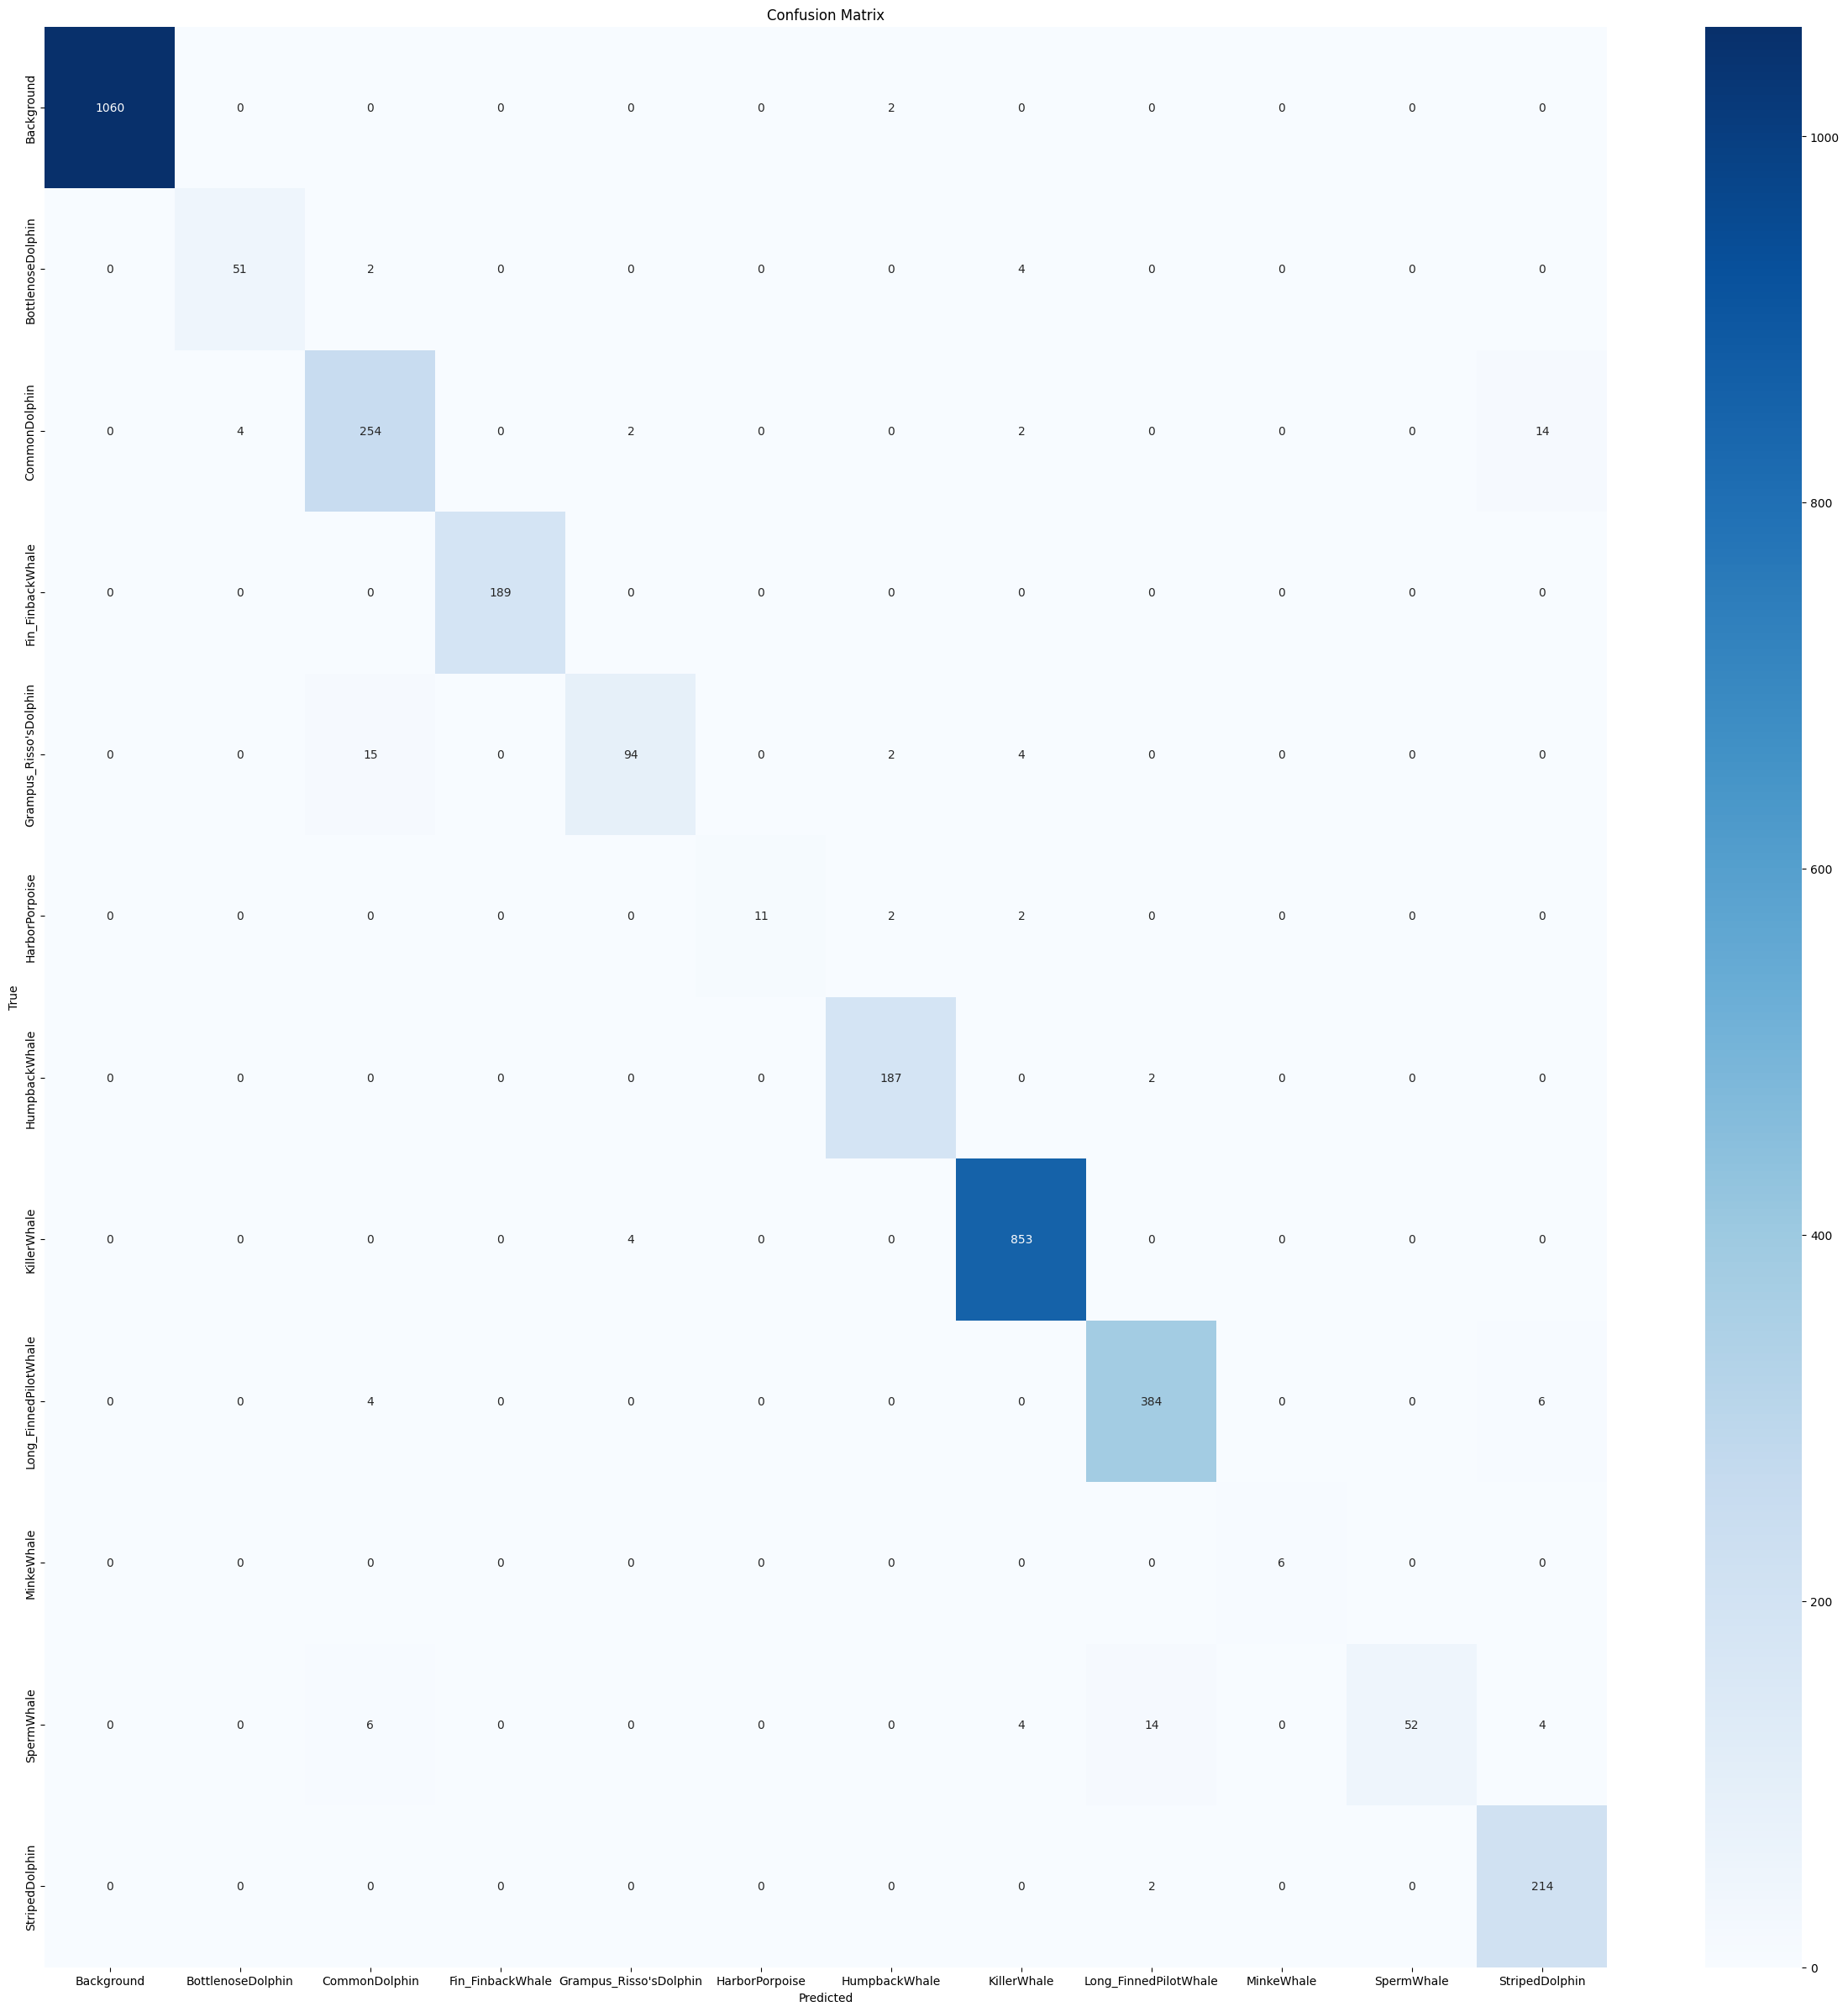

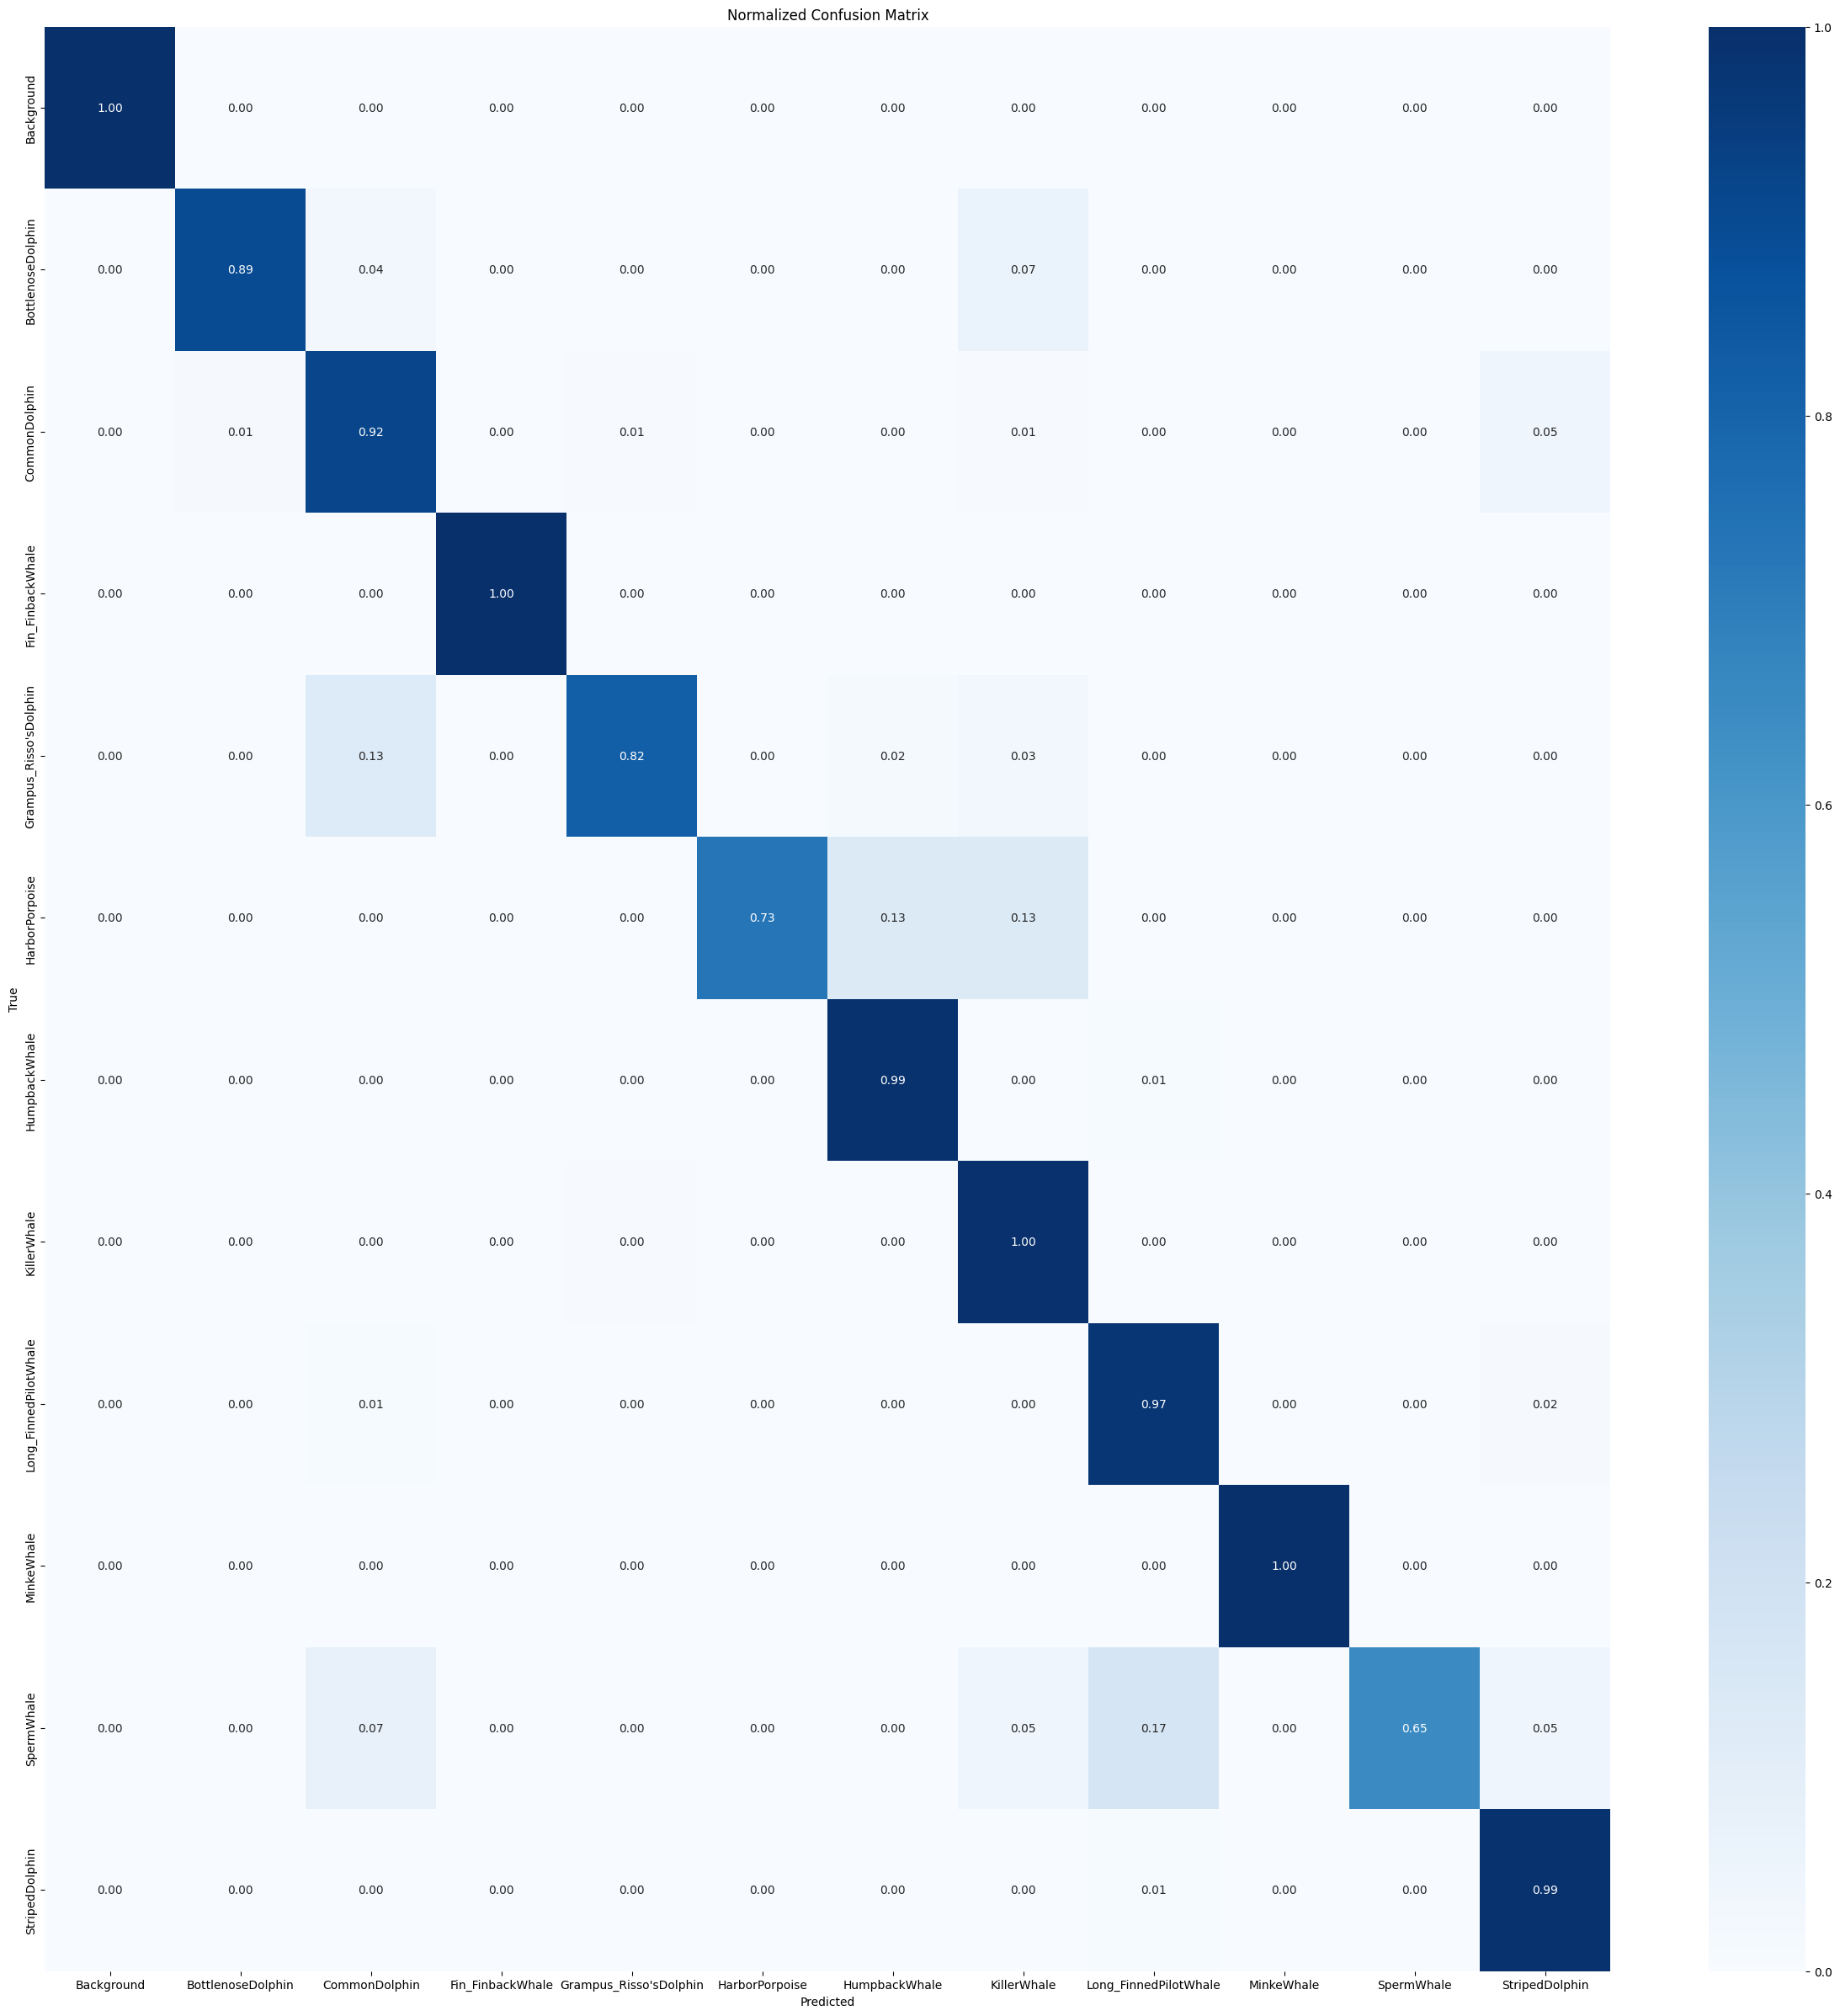

In [50]:
TEST_BATCH_SIZE = 8

df_results = evaluate_model(model, df_test, CLASSES, CLASSES_MAPPING, REVERSE_CLASSES_MAPPING, batch_size=TEST_BATCH_SIZE)

In [51]:
# Calculate all metrics of df_results (F1 macro, F1 micro, accuracy, precision, recall, sensitivity, AUC...)
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Get the true and predicted labels
true_labels = df_results['True']
predicted_labels = df_results['Predicted']

# Calculate F1 macro
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"F1 Macro: {f1_macro}")
print(f"F1 Micro: {f1_micro}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

F1 Macro: 0.9337731039072427
F1 Micro: 0.9707754629629629
Precision: 0.9646725676501674
Recall: 0.9136648892176873
Accuracy: 0.9707754629629629


In [52]:
# check performance per class
from sklearn.metrics import classification_report

# Get the unique labels from true_labels
unique_labels = np.unique(true_labels)

print(classification_report(true_labels, predicted_labels, target_names=[REVERSE_CLASSES_MAPPING[label] for label in unique_labels], labels=unique_labels))

                        precision    recall  f1-score   support

            Background       1.00      1.00      1.00      1062
     BottlenoseDolphin       0.93      0.89      0.91        57
         CommonDolphin       0.90      0.92      0.91       276
      Fin_FinbackWhale       1.00      1.00      1.00       189
Grampus_Risso'sDolphin       0.94      0.82      0.87       115
        HarborPorpoise       1.00      0.73      0.85        15
         HumpbackWhale       0.97      0.99      0.98       189
           KillerWhale       0.98      1.00      0.99       857
 Long_FinnedPilotWhale       0.96      0.97      0.96       394
            MinkeWhale       1.00      1.00      1.00         6
            SpermWhale       1.00      0.65      0.79        80
        StripedDolphin       0.90      0.99      0.94       216

              accuracy                           0.97      3456
             macro avg       0.96      0.91      0.93      3456
          weighted avg       0.97     

In [54]:
experiment.end()

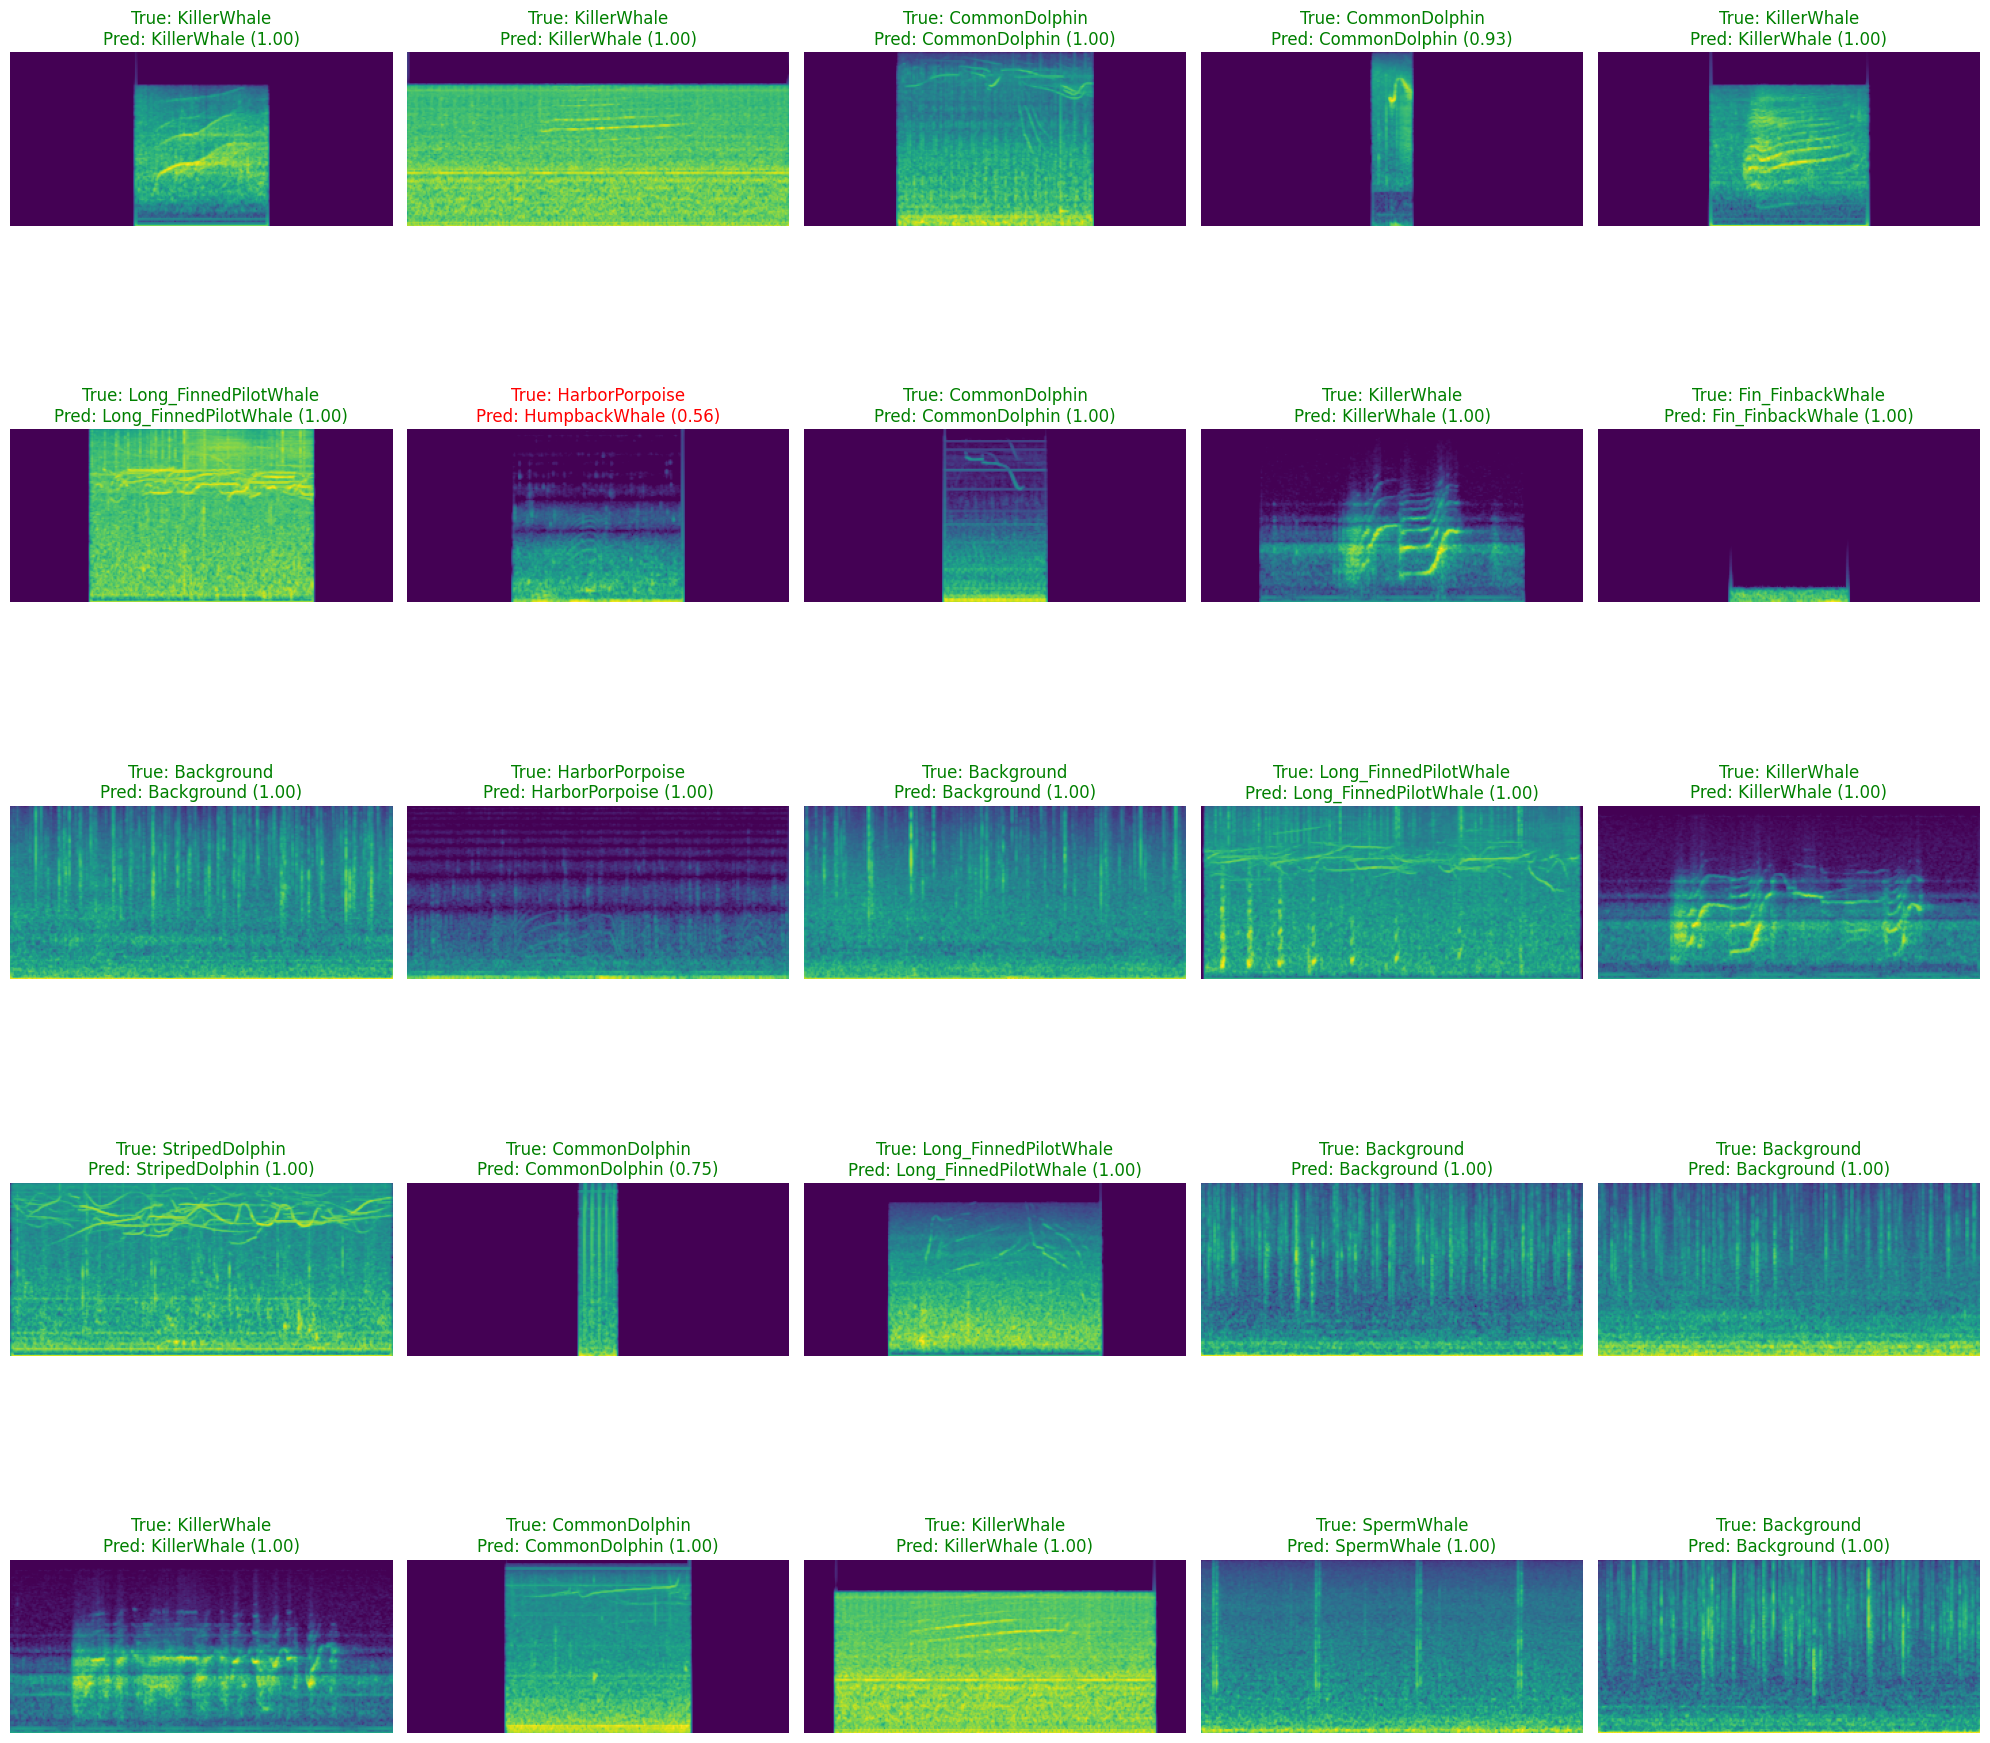

In [53]:
# Plot 25 random samples
# Create a grid of plots
plot_results(df_results, REVERSE_CLASSES_MAPPING, mode='random')

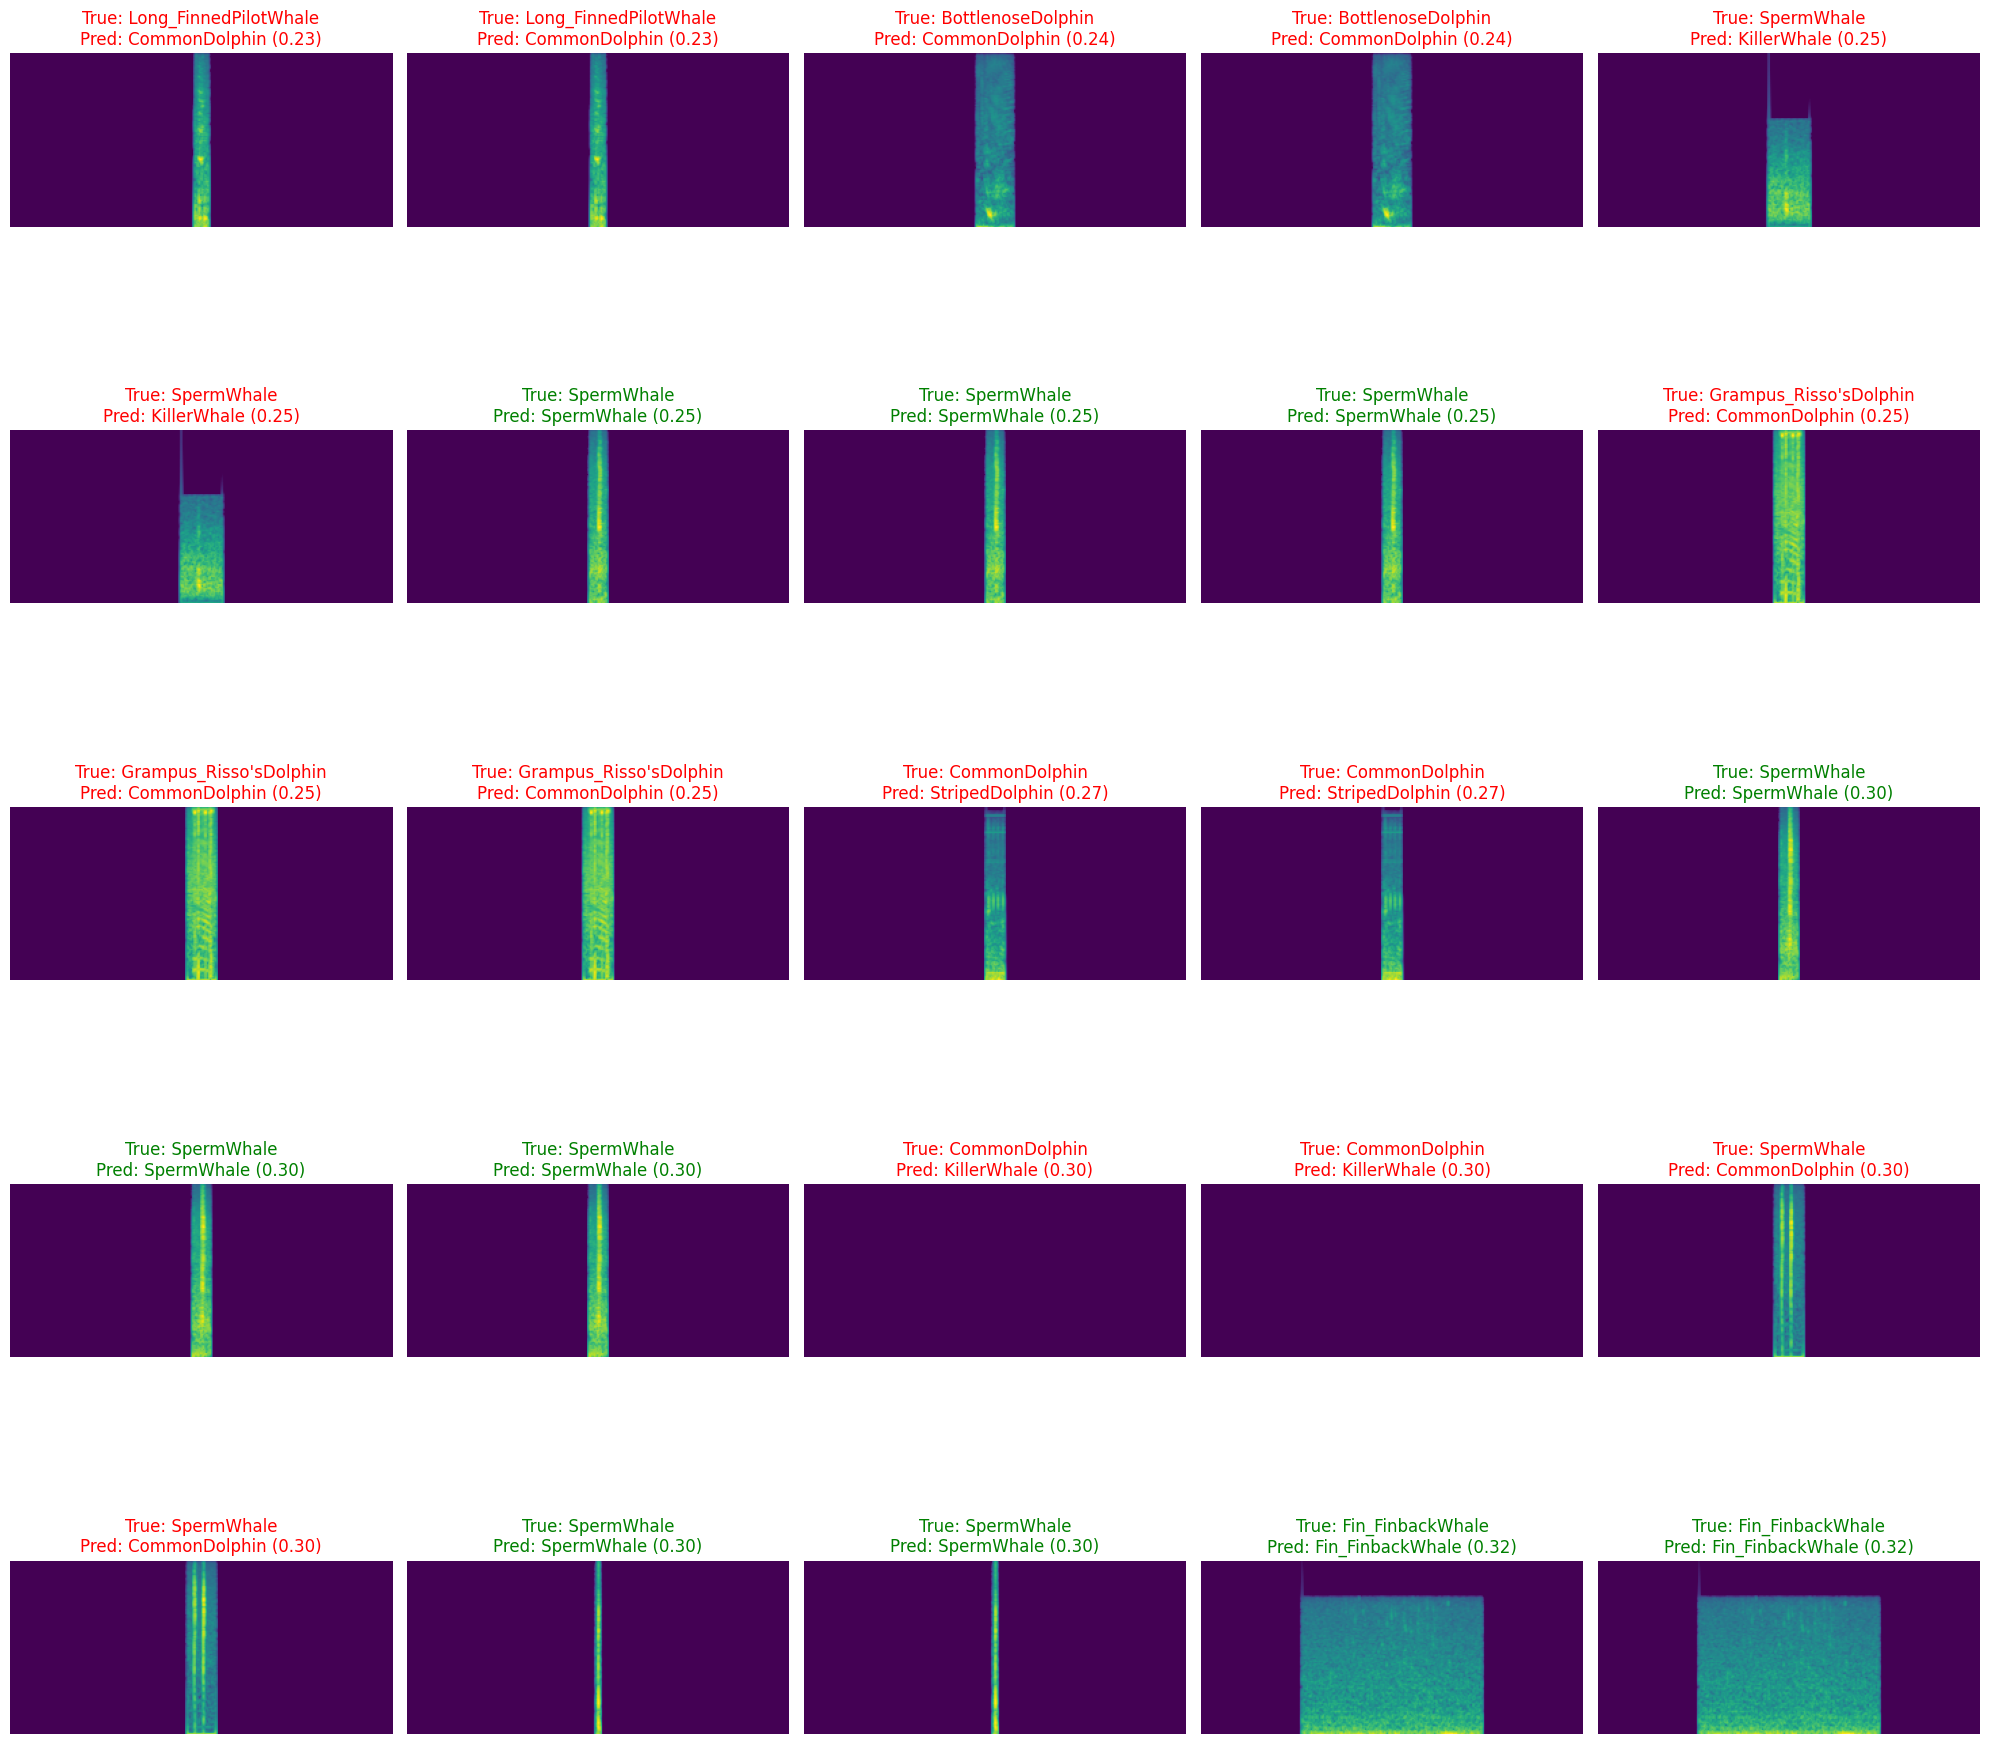

In [54]:
# Select 25 samples with lowest confidence
plot_results(df_results, REVERSE_CLASSES_MAPPING, mode='min')

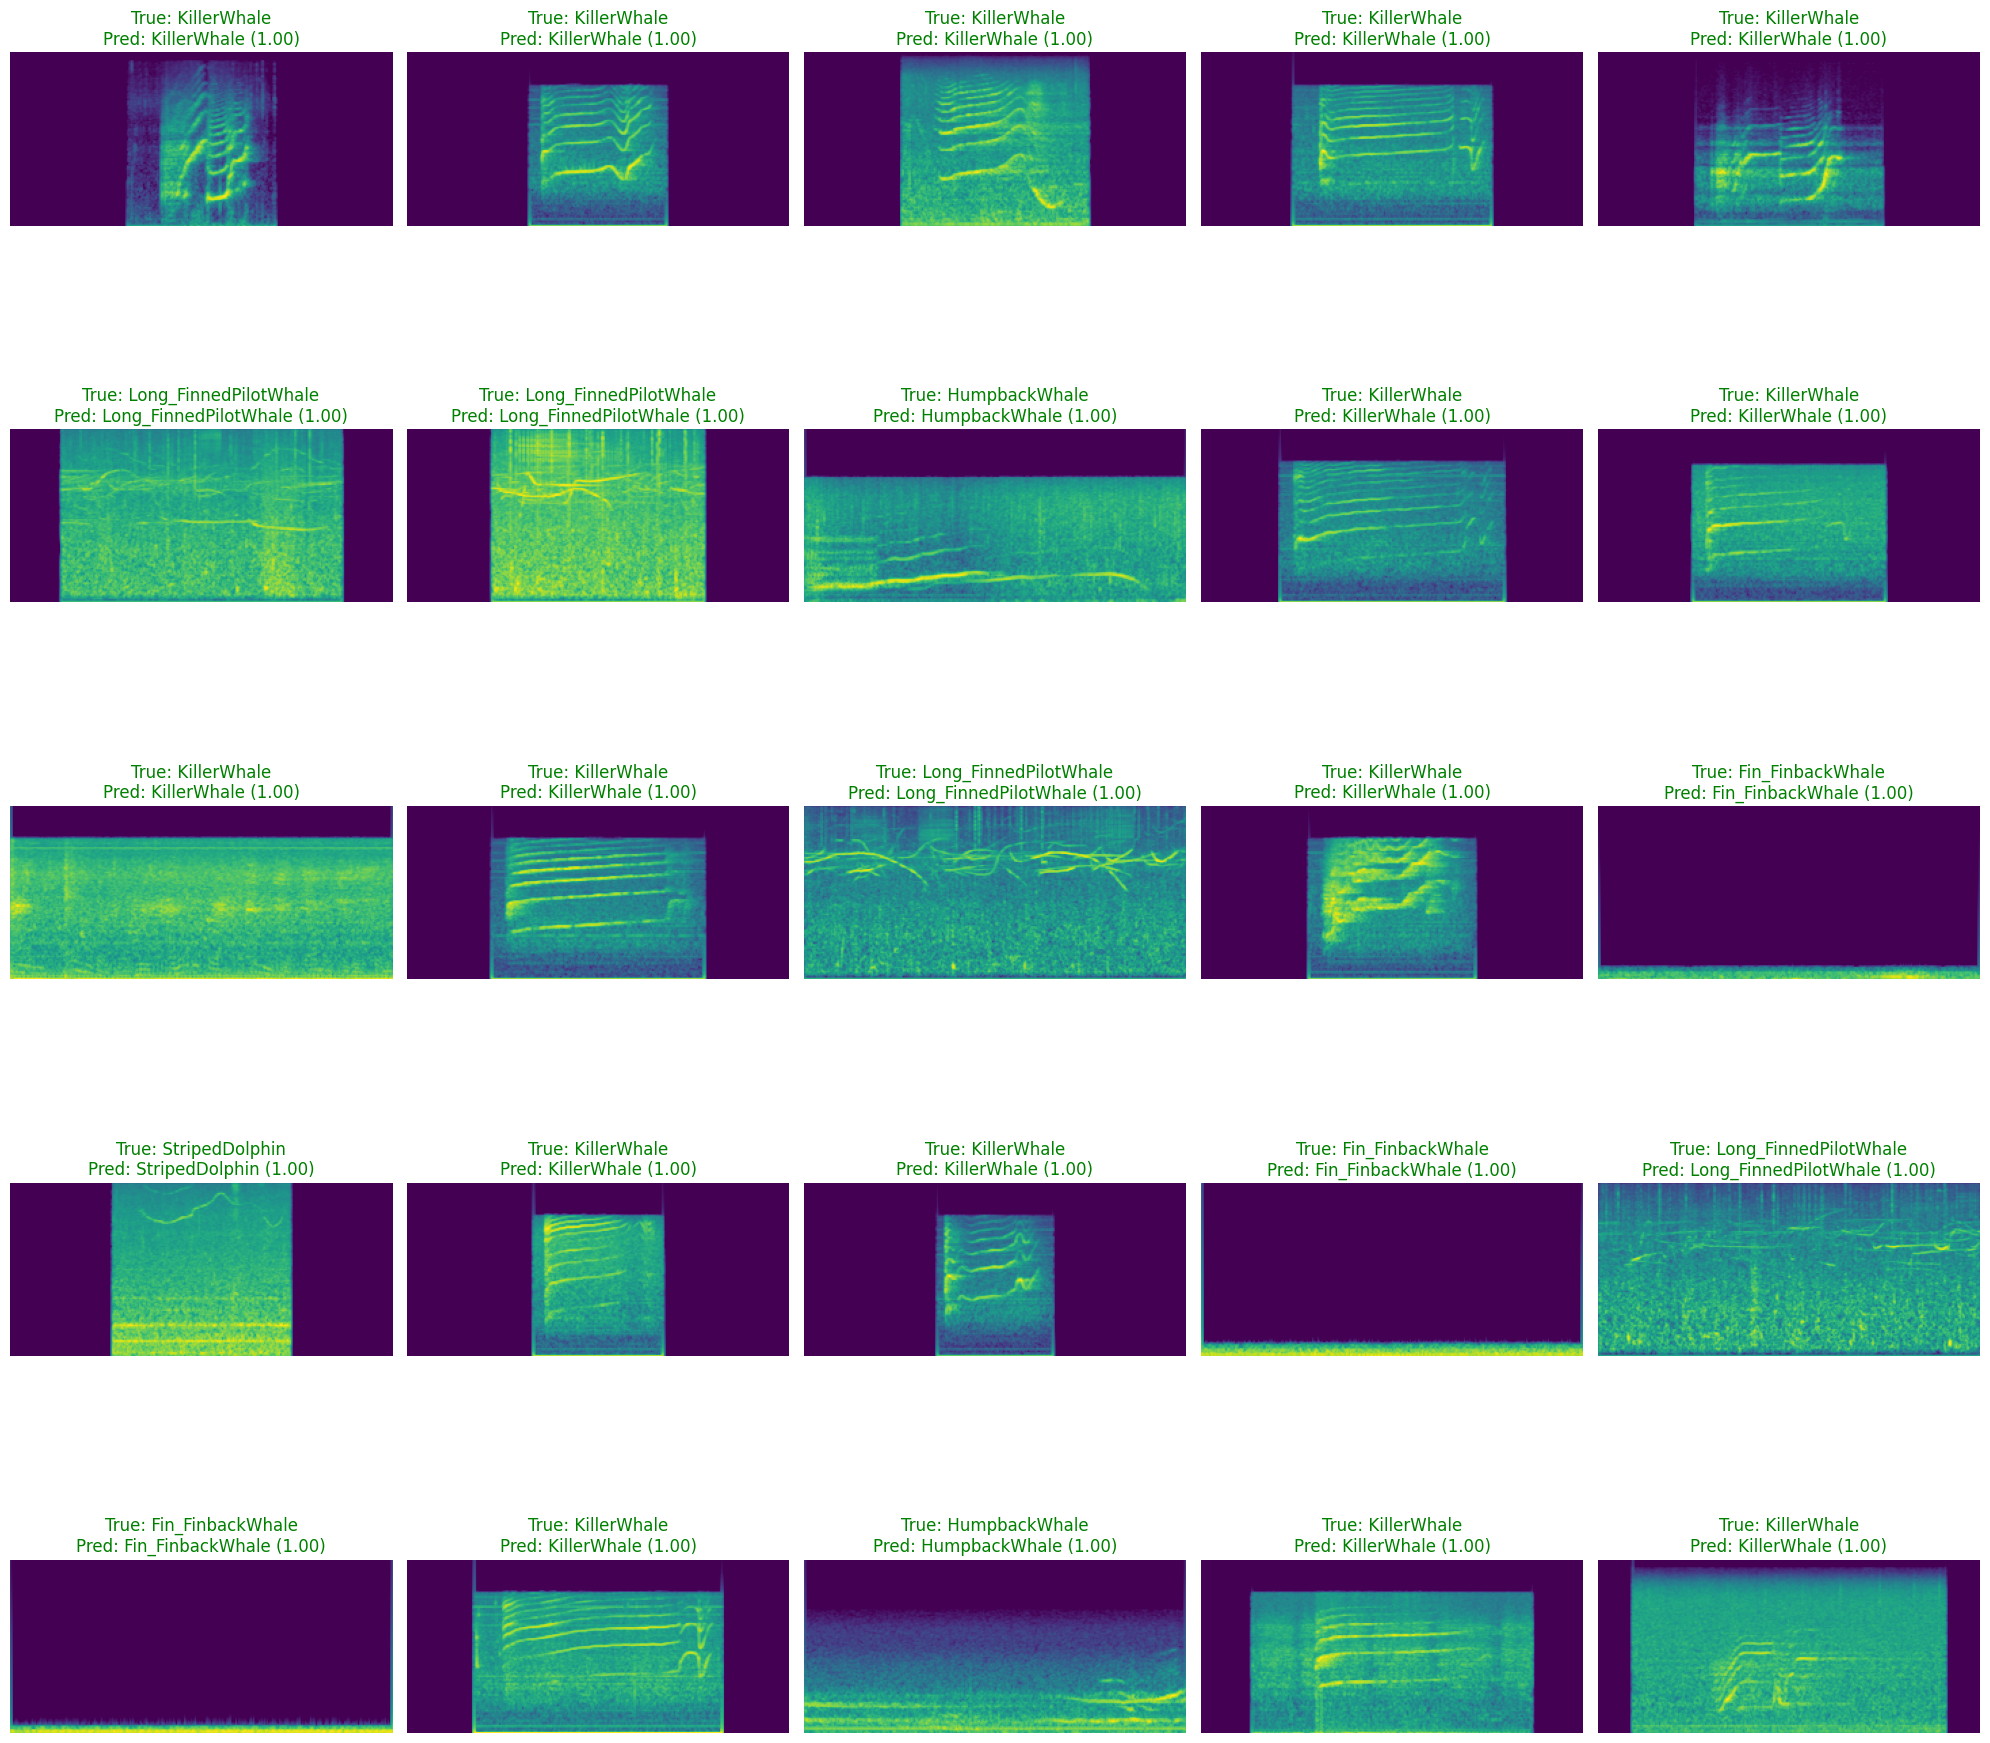

In [55]:
# Select 25 samples with highest confidence
plot_results(df_results, REVERSE_CLASSES_MAPPING, mode='max')

In [56]:
df_results

Path  SegmentIdx  \
0     ../../Dataset/Audios/Watkins Marine Mammals/Ki...           0   
1     ../../Dataset/Audios/Watkins Marine Mammals/Ki...           0   
2     ../../Dataset/Audios/Watkins Marine Mammals/Fi...           0   
3     ../../Dataset/Audios/Watkins Marine Mammals/Sp...           0   
4     ../../Dataset/Audios/Watkins Marine Mammals/Ha...           0   
...                                                 ...         ...   
3451  ../../Dataset/Audios/Watkins Marine Mammals/Co...           0   
3452  ../../Dataset/Audios/Watkins Marine Mammals/St...           0   
3453  ../../Dataset/Audios/Watkins Marine Mammals/Lo...           0   
3454  ../../Dataset/Audios/Watkins Marine Mammals/Ki...           0   
3455  ../../Dataset/Audios/Watkins Marine Mammals/Hu...           0   

                                                 Signal  True  Predicted  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     7          7   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     7          7   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     3          3   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    10         10   
4     [-0.0030054785, -0.0035627019, -0.004114423, -...     5          5   
...                                                 ...   ...        ...   
3451  [0.0760878, 0.08487653, 0.0823389, 0.082357265...     2          2   
3452  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...    11         11   
3453  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     8          8   
3454  [-0.016818328, -0.015759133, -0.014930684, -0....     7          7   
3455  [-0.0023331782, -0.0023478577, -0.0016368858, ...     6          6   

             PredictedClass  Confidence  
0               KillerWhale    1.000000  
1               KillerWhale    1.000000  
2          Fin_FinbackWhale    1.000000  
3                SpermWhale    0.996606  
4            HarborPorpoise    0.999997  
...                     ...         ...  
3451          CommonDolphin    0.999990  
3452         StripedDolphin    0.999840  
3453  Long_FinnedPilotWhale    1.000000  
3454            KillerWhale    1.000000  
3455          HumpbackWhale    1.000000  

[3456 rows x 7 columns]

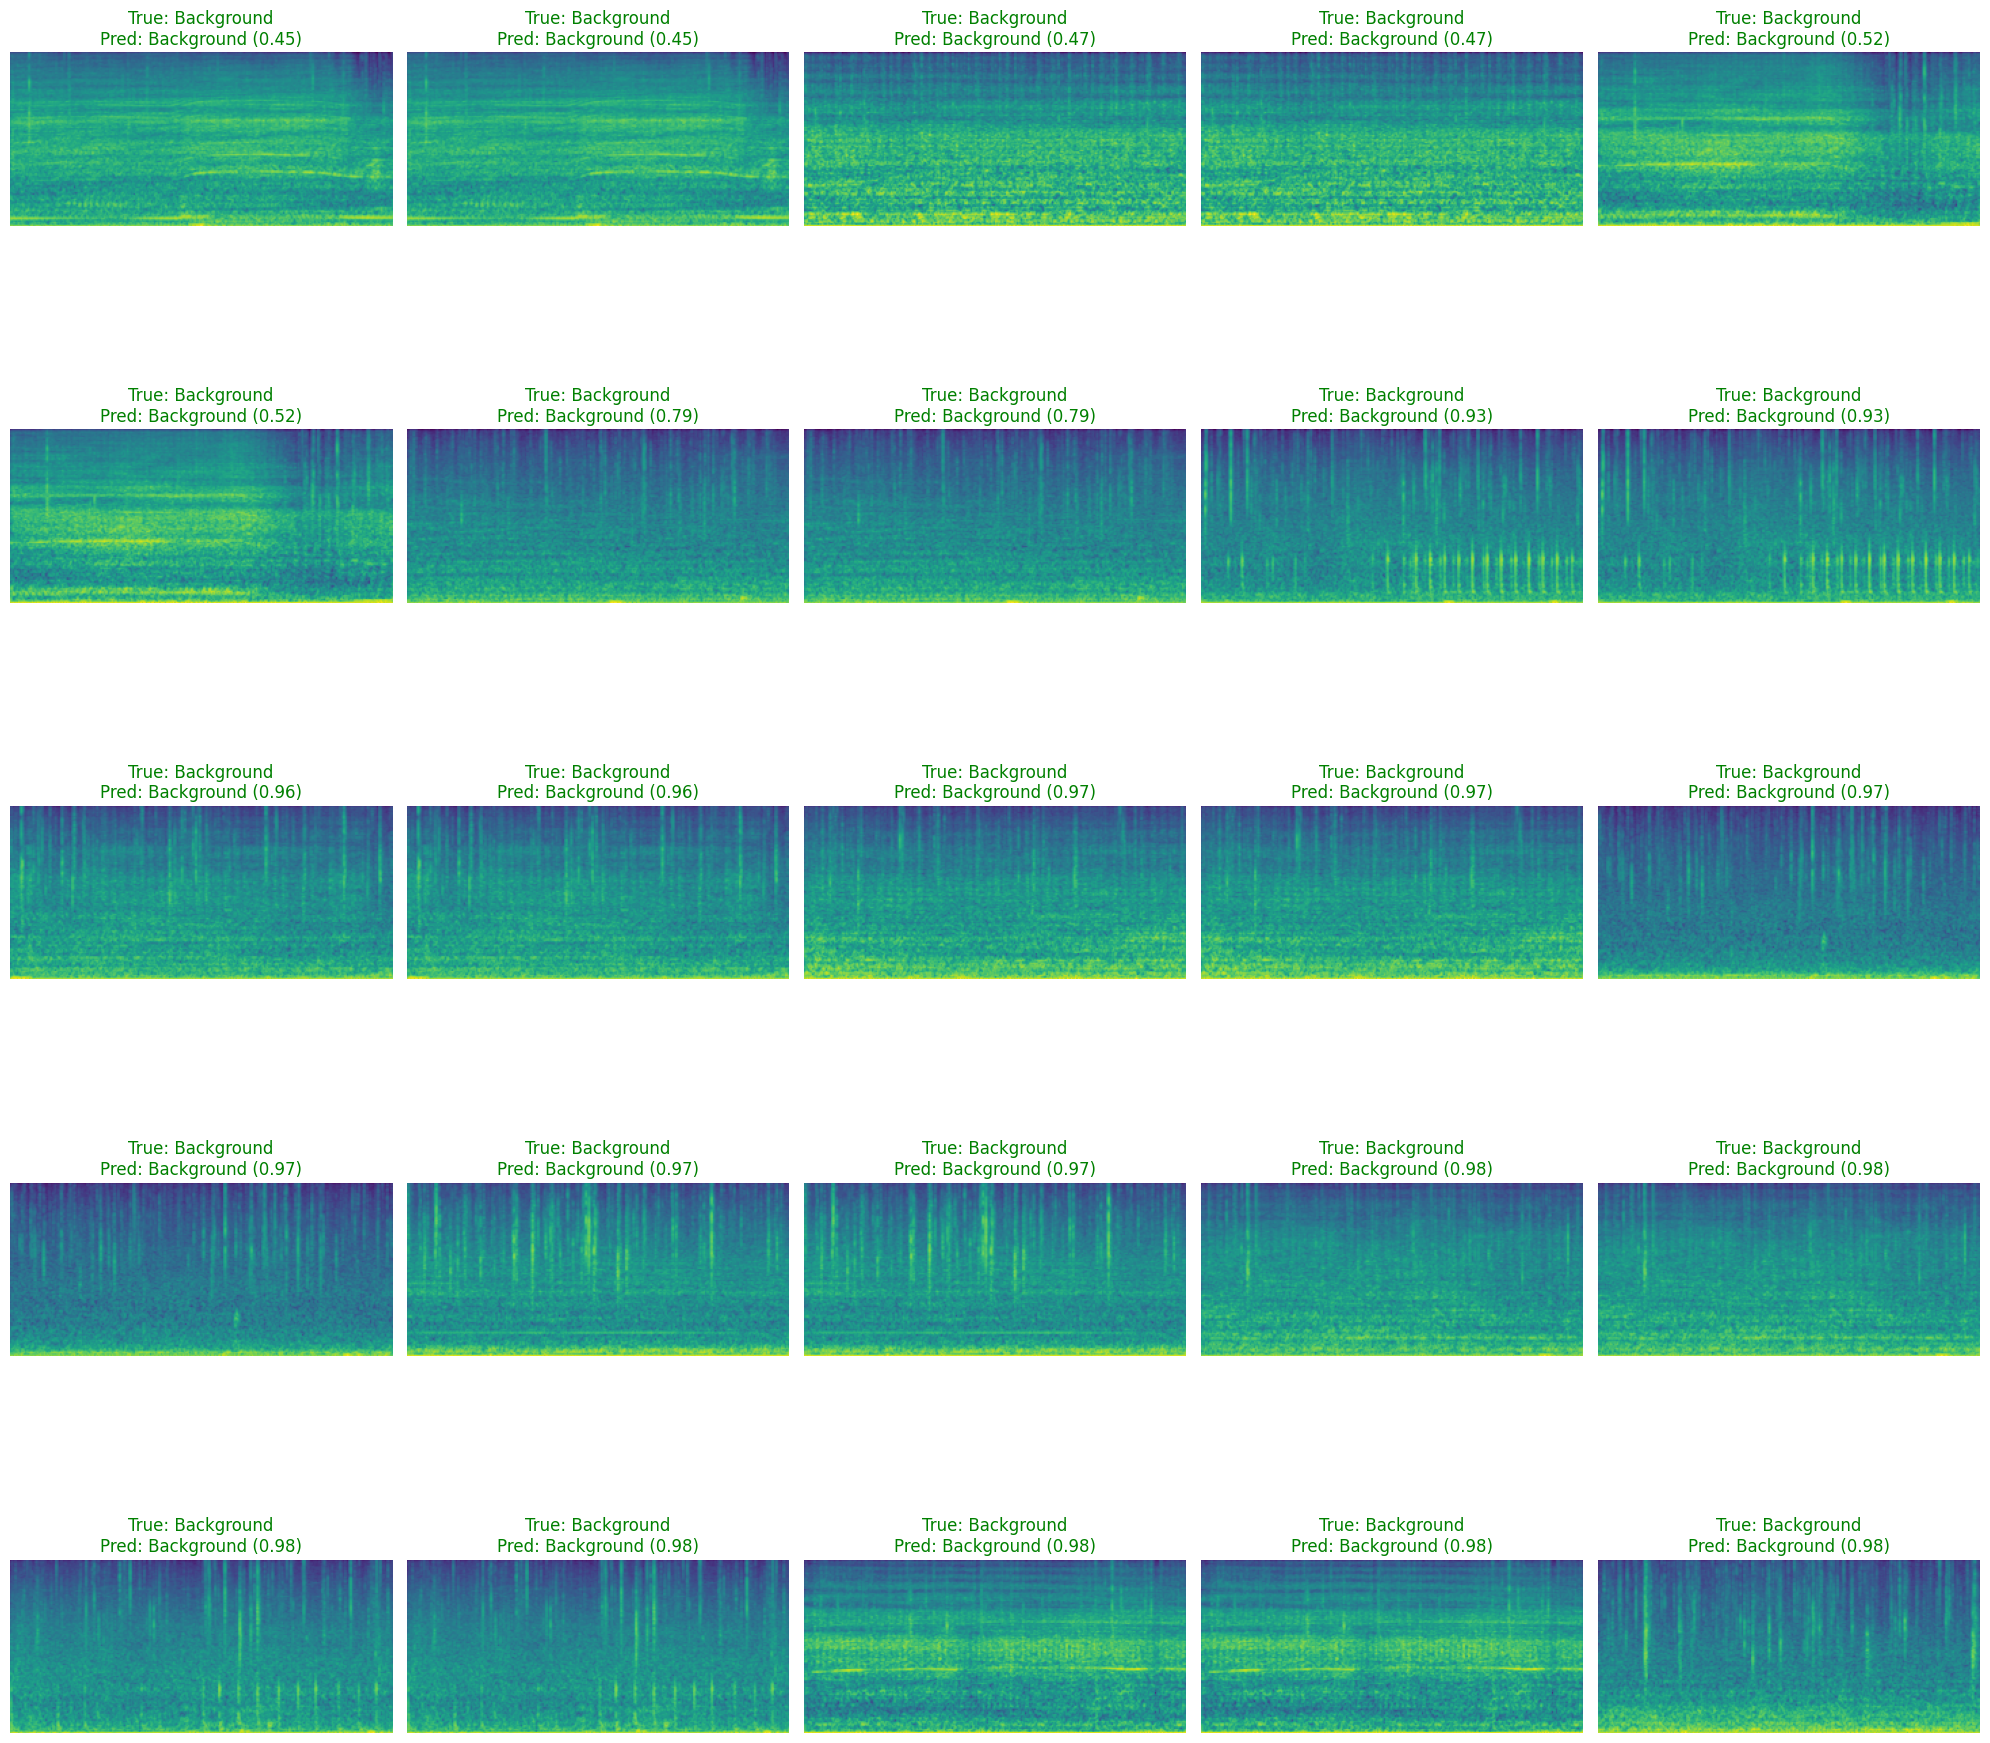

In [57]:
plot_results(df_results, REVERSE_CLASSES_MAPPING, classes=["Background"], mode='min')

In [58]:
REVERSE_CLASSES_MAPPING

{0: 'Background',
 1: 'BottlenoseDolphin',
 2: 'CommonDolphin',
 3: 'Fin_FinbackWhale',
 4: "Grampus_Risso'sDolphin",
 5: 'HarborPorpoise',
 6: 'HumpbackWhale',
 7: 'KillerWhale',
 8: 'Long_FinnedPilotWhale',
 9: 'MinkeWhale',
 10: 'SpermWhale',
 11: 'StripedDolphin'}

In [59]:
pd.set_option('display.max_colwidth', None)
df_results['Path']

0                 ../../Dataset/Audios/Watkins Marine Mammals/KillerWhale/6403000H.wav
1                 ../../Dataset/Audios/Watkins Marine Mammals/KillerWhale/9775800H.wav
2            ../../Dataset/Audios/Watkins Marine Mammals/Fin_FinbackWhale/77007009.wav
3                  ../../Dataset/Audios/Watkins Marine Mammals/SpermWhale/88002007.wav
4              ../../Dataset/Audios/Watkins Marine Mammals/HarborPorpoise/6501200V.wav
                                             ...                                      
3451            ../../Dataset/Audios/Watkins Marine Mammals/CommonDolphin/5801300X.wav
3452           ../../Dataset/Audios/Watkins Marine Mammals/StripedDolphin/7500302I.wav
3453    ../../Dataset/Audios/Watkins Marine Mammals/Long_FinnedPilotWhale/5400401J.wav
3454              ../../Dataset/Audios/Watkins Marine Mammals/KillerWhale/6403101L.wav
3455            ../../Dataset/Audios/Watkins Marine Mammals/HumpbackWhale/54018001.wav
Name: Path, Length: 3456, dtype: object